In [24]:
!pip install numpy pandas scikit-learn matplotlib seaborn umap-learn

# Start with processed data

In [25]:
import pandas as pd
data = pd.read_csv("data.csv")

# Code to drop identifier columns, Drop highly correlated columns
# Detecting categorical variables, Ordinal encoding
# Drop the OLD Target Column loan_status, Convert Boolean Text Columns → Binary
# Detect numerical columns and apply scaling, Create the baseline dataset (no noise)
# Train/test split, Scaling

In [26]:
# ------------------------------------------------
# STEP 1 — DROP IDENTIFIER COLUMNS
# ------------------------------------------------

identifier_cols = [col for col in data.columns if data[col].nunique() == len(data)]
print("Identifier columns:", identifier_cols)

data = data.drop(columns=identifier_cols)
#print("Shape after dropping identifiers:", data.shape)

# ------------------------------------------------
# STEP 2 — REMOVE HIGHLY CORRELATED NUMERIC COLUMNS
# ------------------------------------------------

import numpy as np

numeric_cols = data.select_dtypes(include=['float64','int64']).columns.tolist()

corr_matrix = data[numeric_cols].corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.90)]

#print("Correlated columns to drop:", to_drop_corr)

data = data.drop(columns=to_drop_corr)
#print("Shape after dropping correlated columns:", data.shape)

# ------------------------------------------------
# STEP 3 — DETECT CATEGORICAL COLUMNS
# ------------------------------------------------

categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# exclude target column if it still exists
if "loan_status" in categorical_cols:
    categorical_cols.remove("loan_status")

#print("Categorical columns:", categorical_cols)

# ------------------------------------------------
# STEP 4 — ORDINAL ENCODING OF CATEGORICAL VARIABLES
# ------------------------------------------------

from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

data[categorical_cols] = enc.fit_transform(data[categorical_cols])

#print("Shape after encoding:", data.shape)
#data.head()

# ------------------------------------------------
# STEP 5 — DROP OLD TEXT TARGET COLUMN
# ------------------------------------------------

if "loan_status" in data.columns:
    data = data.drop(columns=["loan_status"])

#print("Dropped loan_status.")
#print("Current shape:", data.shape)

# ------------------------------------------------
# STEP 6 — BOOLEAN TO BINARY CONVERSION
# ------------------------------------------------

bool_like_cols = []

for col in data.columns:
    unique_vals = set(str(v).lower() for v in data[col].dropna().unique())
    if unique_vals.issubset({"true","false","t","f","yes","no","y","n"}):
        bool_like_cols.append(col)

#print("Boolean-like columns:", bool_like_cols)

# Convert to 0/1
for col in bool_like_cols:
    data[col] = data[col].astype(str).str.lower().map({
        "true":1,"t":1,"yes":1,"y":1,
        "false":0,"f":0,"no":0,"n":0
    }).astype(int)

#print("Boolean conversion complete.")

# ------------------------------------------------
# STEP 7 — SCALING NUMERIC COLUMNS
# ------------------------------------------------

from sklearn.preprocessing import StandardScaler

numeric_cols = data.select_dtypes(include=['float64','int64']).columns.tolist()

# remove target if already present
if "default_binary" in numeric_cols:
    numeric_cols.remove("default_binary")

scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

print("Scaling complete. Shape:", data.shape)

# ------------------------------------------------
# STEP 8 — CREATE BASELINE NO-NOISE DATASET
# ------------------------------------------------

noerror_data = data.copy()
print("Baseline dataset created.")
print(noerror_data.shape)

# ------------------------------------------------
# TRAIN/TEST SPLIT (NO-NOISE DATASET)
# ------------------------------------------------

from sklearn.model_selection import train_test_split

X = noerror_data.drop(columns=["default_binary"])
y = noerror_data["default_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# ------------------------------------------------
# STEP 9 — SCALING
# ------------------------------------------------

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Scaling complete.")

# ------------------------------------------------
# STEP 10 — LOW VARIANCE FEATURE REMOVAL
# ------------------------------------------------

from sklearn.feature_selection import VarianceThreshold

# REMOVE ZERO-VARIANCE FEATURES ONLY
vt = VarianceThreshold(threshold=0.20)

X_train_vt = vt.fit_transform(X_train_scaled)
X_test_vt  = vt.transform(X_test_scaled)

print("After removing low-variance features:", X_train_vt.shape)

# ------------------------------------------------
# STEP 11 — PCA REDUCTION
# ------------------------------------------------

from sklearn.decomposition import PCA

pca = PCA(n_components=0.9999)
X_train_pca = pca.fit_transform(X_train_vt)
X_test_pca  = pca.transform(X_test_vt)

print("After PCA shape:", X_train_pca.shape)

Identifier columns: []
Scaling complete. Shape: (10000, 76)
Baseline dataset created.
(10000, 76)
Train: (7500, 75) Test: (2500, 75)
Scaling complete.
After removing low-variance features: (7500, 72)
After PCA shape: (7500, 71)


# Fit the Baseline KNN Model

In [27]:
# ------------------------------------------------
# BASELINE KNN MODEL (MANHATTAN DISTANCE)
# ------------------------------------------------

from sklearn.neighbors import KNeighborsClassifier

best_k = 78  # from your elbow curve
knn = KNeighborsClassifier(
    n_neighbors=best_k,
    metric='manhattan',
    weights='uniform'   # try 'distance' later
)

knn.fit(X_train_pca, y_train)

results = {
    "baseline_knn": {}
}

print("Baseline KNN trained with Manhattan distance.")

Baseline KNN trained with Manhattan distance.


# Evaluation 1: Accuracy

In [28]:
from sklearn.metrics import accuracy_score

y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

results["baseline_knn"]["accuracy"] = acc
print("Baseline Manhattan KNN Accuracy:", acc)

Baseline Manhattan KNN Accuracy: 0.838


# Evaluation 2: Confusion Matrix

In [29]:
# ------------------------------------------------
# EVALUATION 2 — CONFUSION MATRIX
# ------------------------------------------------

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

results["baseline_knn"]["confusion_matrix"] = cm

print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 968  282]
 [ 123 1127]]


# Evaluation 3: Precision / Recall / F1

In [30]:
# ------------------------------------------------
# EVALUATION 3 — PRECISION / RECALL / F1
# ------------------------------------------------

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)

results["baseline_knn"]["precision"] = precision
results["baseline_knn"]["recall"]    = recall
results["baseline_knn"]["f1"]        = f1

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.7998580553584103
Recall: 0.9016
F1 Score: 0.8476871004136893


# Evaluation 4: ROC-AUC Score

ROC-AUC: 0.9287411200000001


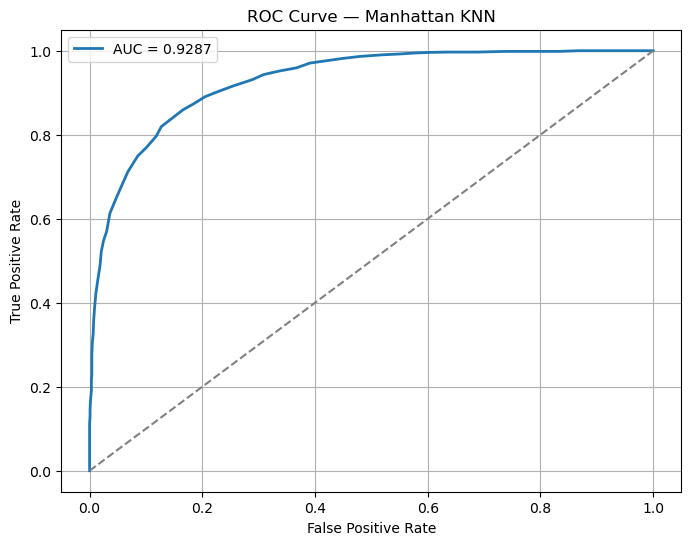

In [31]:
# ------------------------------------------------
# EVALUATION 4 — ROC-AUC (CORRECTED)
# ------------------------------------------------

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# IMPORTANT: Use PCA-transformed test data
y_prob = knn.predict_proba(X_test_pca)[:, 1]

# Compute ROC-AUC score
auc = roc_auc_score(y_test, y_prob)
results["baseline_knn"]["roc_auc"] = auc

print("ROC-AUC:", auc)

# ------------------------------------------------
# ROC CURVE PLOT
# ------------------------------------------------

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", linewidth=2)
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Manhattan KNN")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation 5: Calibration Curve

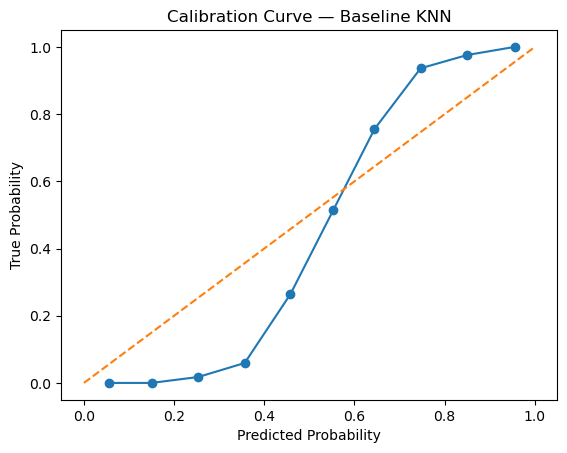

In [32]:
# ------------------------------------------------
# EVALUATION 5 — CALIBRATION CURVE
# ------------------------------------------------

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

results["baseline_knn"]["calibration_curve"] = {
    "prob_true": prob_true,
    "prob_pred": prob_pred
}

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve — Baseline KNN")
plt.show()

## Elbow Curve for the best k value

Completed Manhattan KNN training for K = [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]


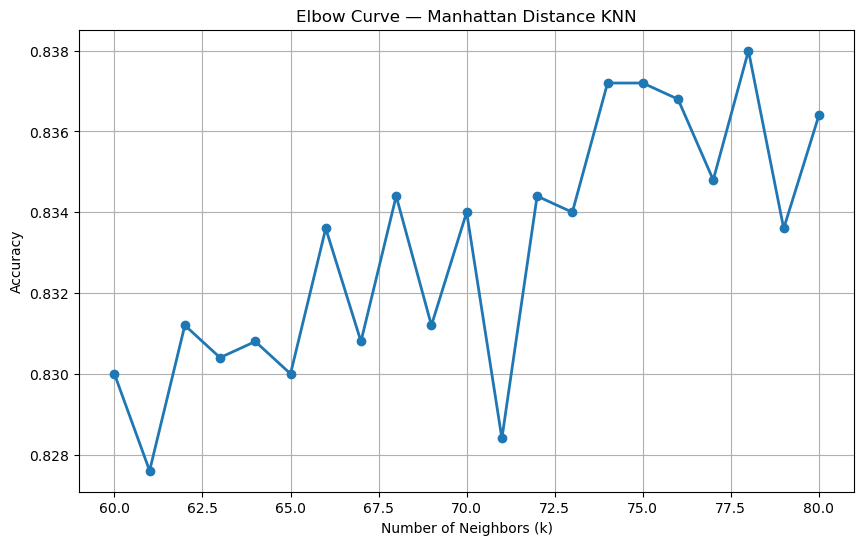

{60: {'accuracy': 0.83},
 61: {'accuracy': 0.8276},
 62: {'accuracy': 0.8312},
 63: {'accuracy': 0.8304},
 64: {'accuracy': 0.8308},
 65: {'accuracy': 0.83},
 66: {'accuracy': 0.8336},
 67: {'accuracy': 0.8308},
 68: {'accuracy': 0.8344},
 69: {'accuracy': 0.8312},
 70: {'accuracy': 0.834},
 71: {'accuracy': 0.8284},
 72: {'accuracy': 0.8344},
 73: {'accuracy': 0.834},
 74: {'accuracy': 0.8372},
 75: {'accuracy': 0.8372},
 76: {'accuracy': 0.8368},
 77: {'accuracy': 0.8348},
 78: {'accuracy': 0.838},
 79: {'accuracy': 0.8336},
 80: {'accuracy': 0.8364}}

In [33]:
# ------------------------------------------------
# ELBOW CURVE FOR MANHATTAN KNN
# ------------------------------------------------

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# --------------------------------------
# Adjustable K-range
# --------------------------------------
start_k = 60
end_k   = 80  # inclusive
k_values = list(range(start_k, end_k + 1))

accuracy_list = []
results_knn_range = {}

# --------------------------------------
# Train & Evaluate KNN for each k
# --------------------------------------
for k in k_values:
    knn = KNeighborsClassifier(
        n_neighbors=k,
        metric='manhattan',
        weights = 'uniform'
    )
    
    knn.fit(X_train_pca, y_train)
    y_pred = knn.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)

    accuracy_list.append(acc)
    results_knn_range[k] = {"accuracy": acc}

print("Completed Manhattan KNN training for K =", k_values)

# --------------------------------------
# Plot elbow curve
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_list, marker='o', linewidth=2)
plt.title("Elbow Curve — Manhattan Distance KNN")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Display results
results_knn_range

# Noise 1 = Symmetric Noise, 10%

Original label distribution: [3750 3750]
Noisy label distribution: [3770 3730]

KNN WITH 10% SYMMETRIC NOISE
Accuracy:  0.8276
Precision: 0.7826
Recall:    0.9072
F1 Score:  0.8403
AUC Score: 0.9243



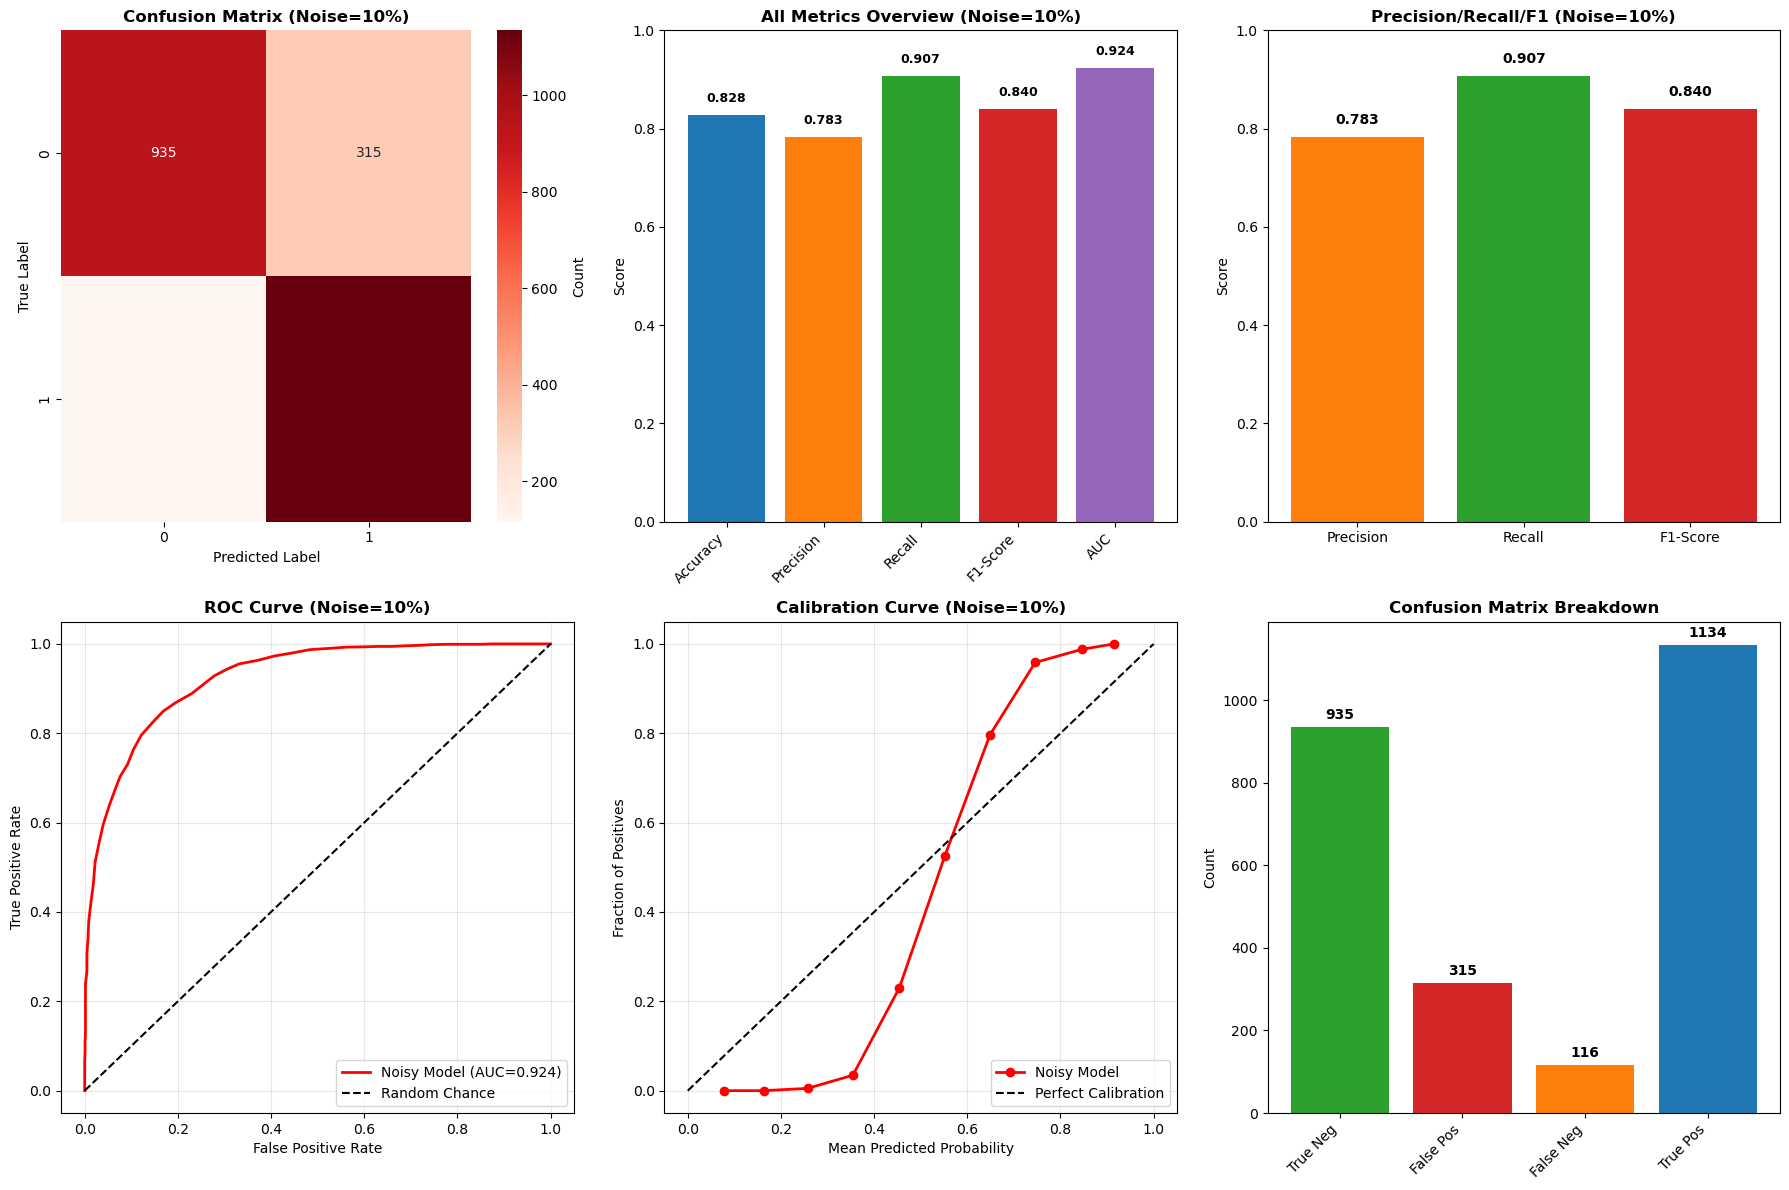


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.89      0.75      0.81      1250
     Default       0.78      0.91      0.84      1250

    accuracy                           0.83      2500
   macro avg       0.84      0.83      0.83      2500
weighted avg       0.84      0.83      0.83      2500



In [34]:
"""
KNN MODEL WITH SYMMETRIC NOISE (10%)
====================================
This script mirrors the Random Forest noise analysis but applies it to the KNN model.
- Introduces 10% symmetric noise by randomly flipping training labels (0->1 and 1->0)
- Trains KNN model on the noisy labels
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline KNN model
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_symmetric_noise(y, noise_rate, random_state=42):
    """
    Flips a fraction `noise_rate` of labels (symmetric noise).
    Randomly selects indices and flips 0->1 and 1->0.
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

# Set noise level
p = 0.10  # 10% symmetric noise
y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)
print("Original label distribution:", np.bincount(y_train))
print("Noisy label distribution:", np.bincount(y_train_noisy))

# Train KNN model with noisy labels
knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k,  # Use your optimized K value (e.g., 78)
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

# Make predictions
y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

# Calculate all metrics
acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store results
if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

# Print summary statistics
print(f"\n{'='*60}")
print(f"KNN WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# Create comprehensive visualization (matching Random Forest layout)
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 1 = Symmetric Noise, 20%

Original label distribution: [3750 3750]
Noisy label distribution: [3752 3748]

KNN WITH 20% SYMMETRIC NOISE
Accuracy:  0.8284
Precision: 0.7829
Recall:    0.9088
F1 Score:  0.8412
AUC Score: 0.9159



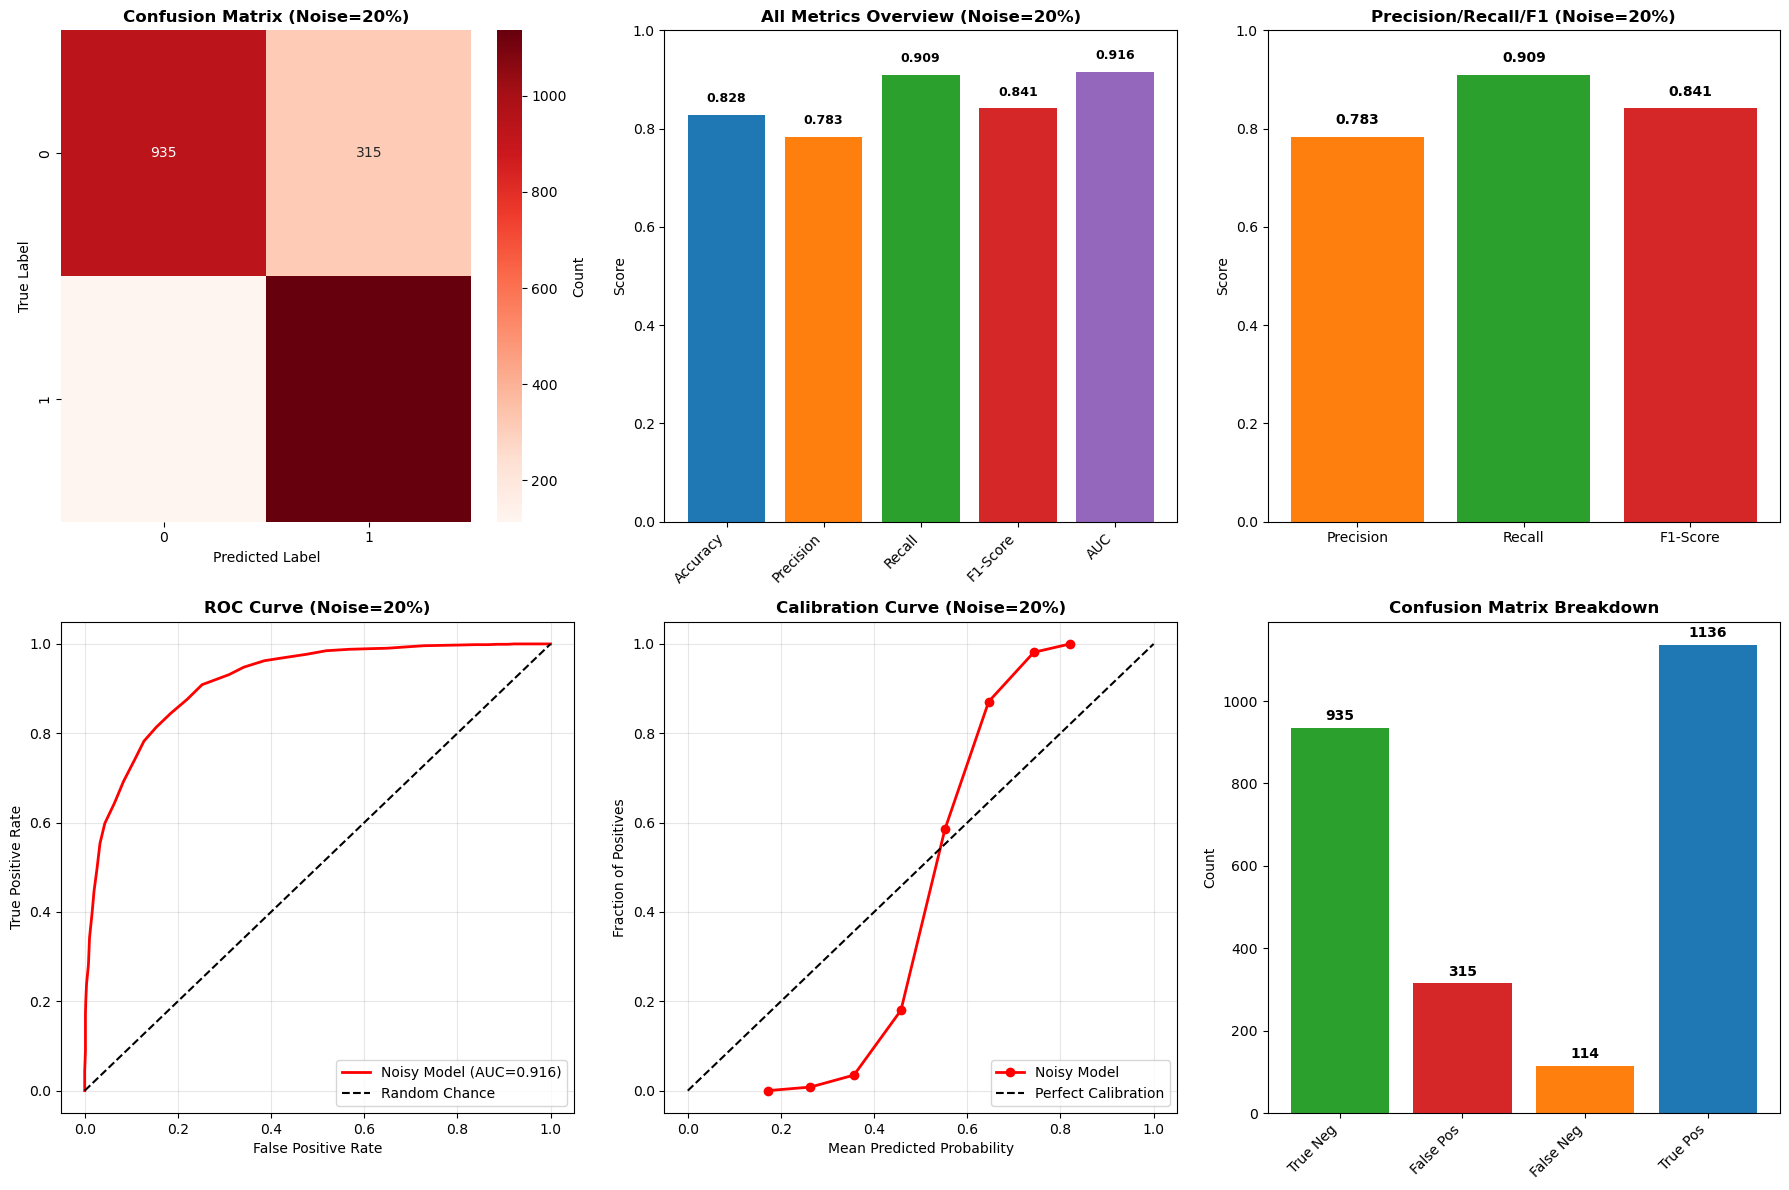


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.89      0.75      0.81      1250
     Default       0.78      0.91      0.84      1250

    accuracy                           0.83      2500
   macro avg       0.84      0.83      0.83      2500
weighted avg       0.84      0.83      0.83      2500



In [35]:
"""
KNN MODEL WITH SYMMETRIC NOISE (10%)
====================================
This script mirrors the Random Forest noise analysis but applies it to the KNN model.
- Introduces 10% symmetric noise by randomly flipping training labels (0->1 and 1->0)
- Trains KNN model on the noisy labels
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline KNN model
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_symmetric_noise(y, noise_rate, random_state=42):
    """
    Flips a fraction `noise_rate` of labels (symmetric noise).
    Randomly selects indices and flips 0->1 and 1->0.
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

# Set noise level
p = 0.20  
y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)
print("Original label distribution:", np.bincount(y_train))
print("Noisy label distribution:", np.bincount(y_train_noisy))

# Train KNN model with noisy labels
knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k,  # Use your optimized K value (e.g., 78)
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

# Make predictions
y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

# Calculate all metrics
acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store results
if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

# Print summary statistics
print(f"\n{'='*60}")
print(f"KNN WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# Create comprehensive visualization (matching Random Forest layout)
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 1 = Symmetric Noise, 33%

Original label distribution: [3750 3750]
Noisy label distribution: [3743 3757]

KNN WITH 33% SYMMETRIC NOISE
Accuracy:  0.7832
Precision: 0.7428
Recall:    0.8664
F1 Score:  0.7999
AUC Score: 0.8699



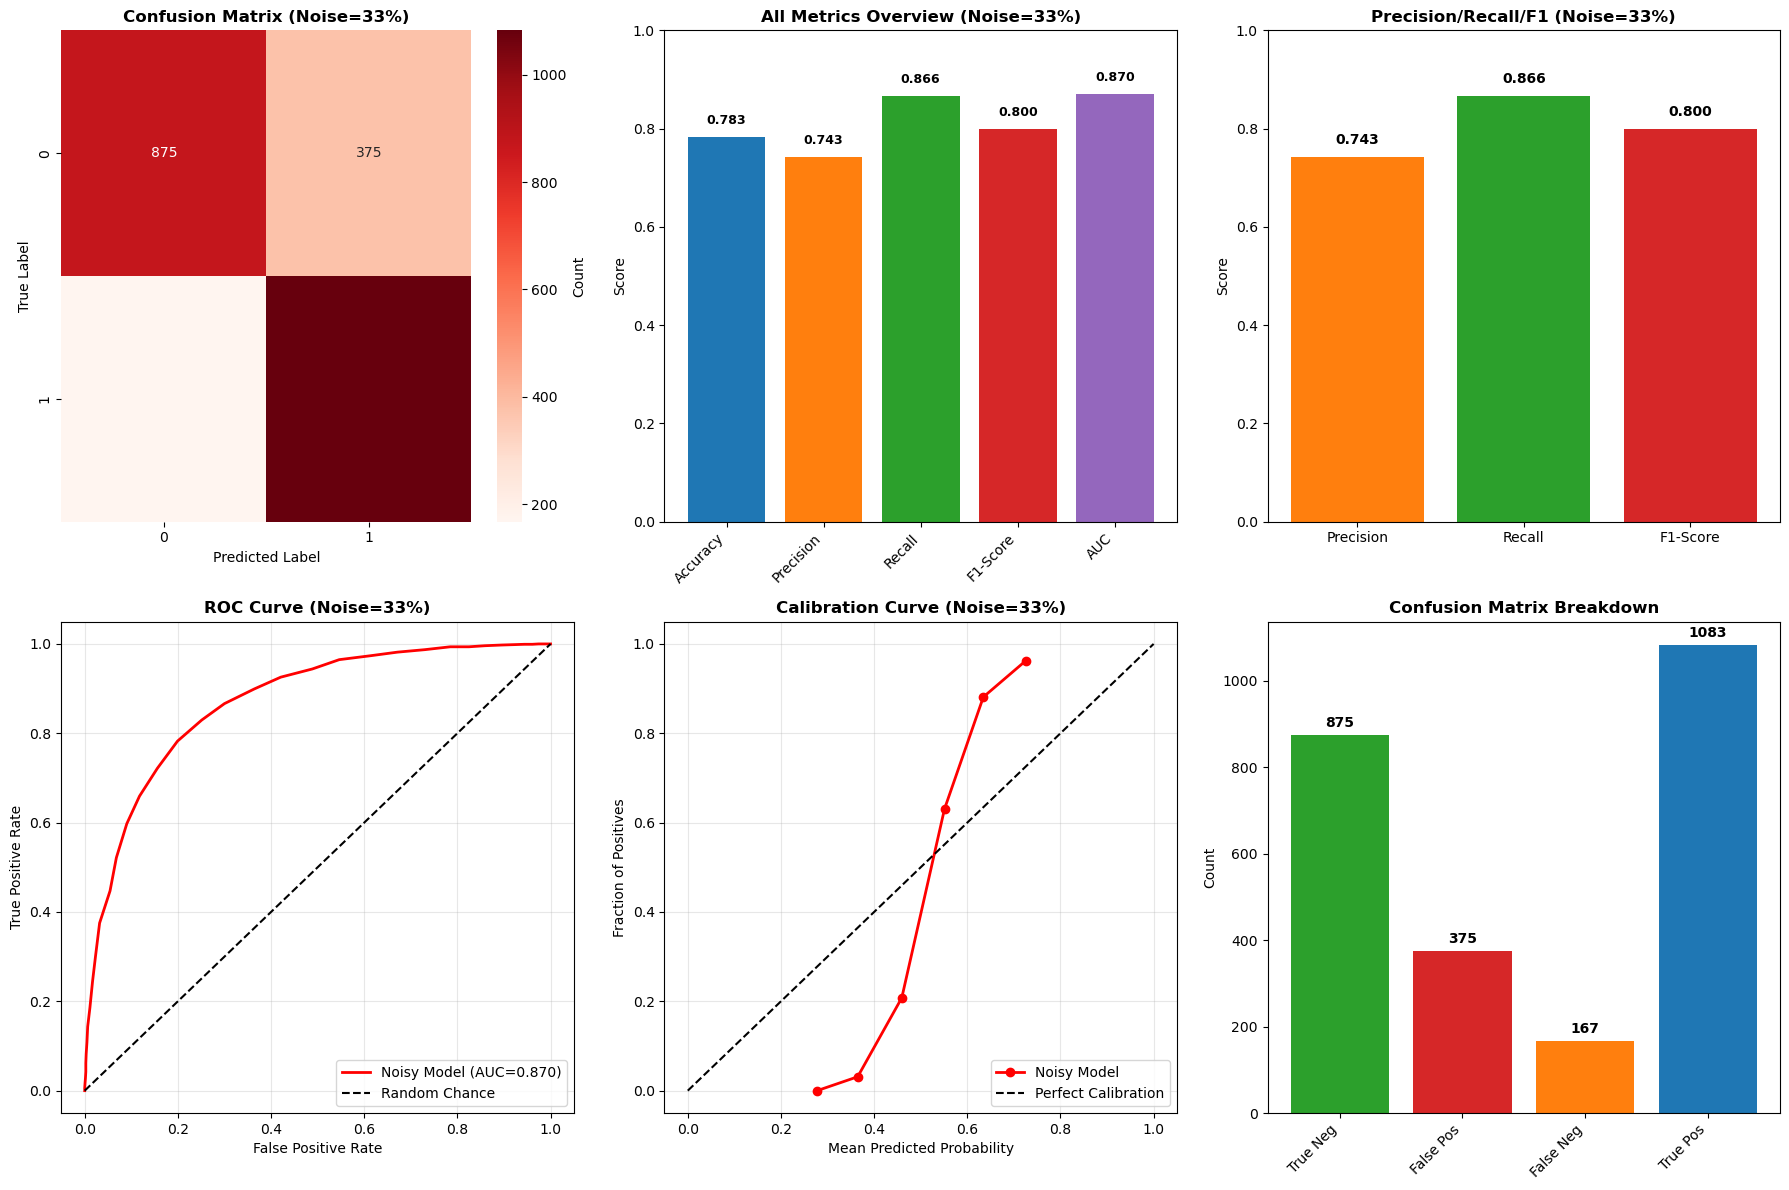


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.84      0.70      0.76      1250
     Default       0.74      0.87      0.80      1250

    accuracy                           0.78      2500
   macro avg       0.79      0.78      0.78      2500
weighted avg       0.79      0.78      0.78      2500



In [36]:
"""
KNN MODEL WITH SYMMETRIC NOISE (10%)
====================================
This script mirrors the Random Forest noise analysis but applies it to the KNN model.
- Introduces 10% symmetric noise by randomly flipping training labels (0->1 and 1->0)
- Trains KNN model on the noisy labels
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline KNN model
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_symmetric_noise(y, noise_rate, random_state=42):
    """
    Flips a fraction `noise_rate` of labels (symmetric noise).
    Randomly selects indices and flips 0->1 and 1->0.
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

# Set noise level
p = 0.33
y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)
print("Original label distribution:", np.bincount(y_train))
print("Noisy label distribution:", np.bincount(y_train_noisy))

# Train KNN model with noisy labels
knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k,  # Use your optimized K value (e.g., 78)
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

# Make predictions
y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

# Calculate all metrics
acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store results
if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

# Print summary statistics
print(f"\n{'='*60}")
print(f"KNN WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# Create comprehensive visualization (matching Random Forest layout)
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 1 = Symmetric Noise, 50%

Original label distribution: [3750 3750]
Noisy label distribution: [3826 3674]

KNN WITH 50% SYMMETRIC NOISE
Accuracy:  0.5152
Precision: 0.5222
Recall:    0.3568
F1 Score:  0.4240
AUC Score: 0.5458



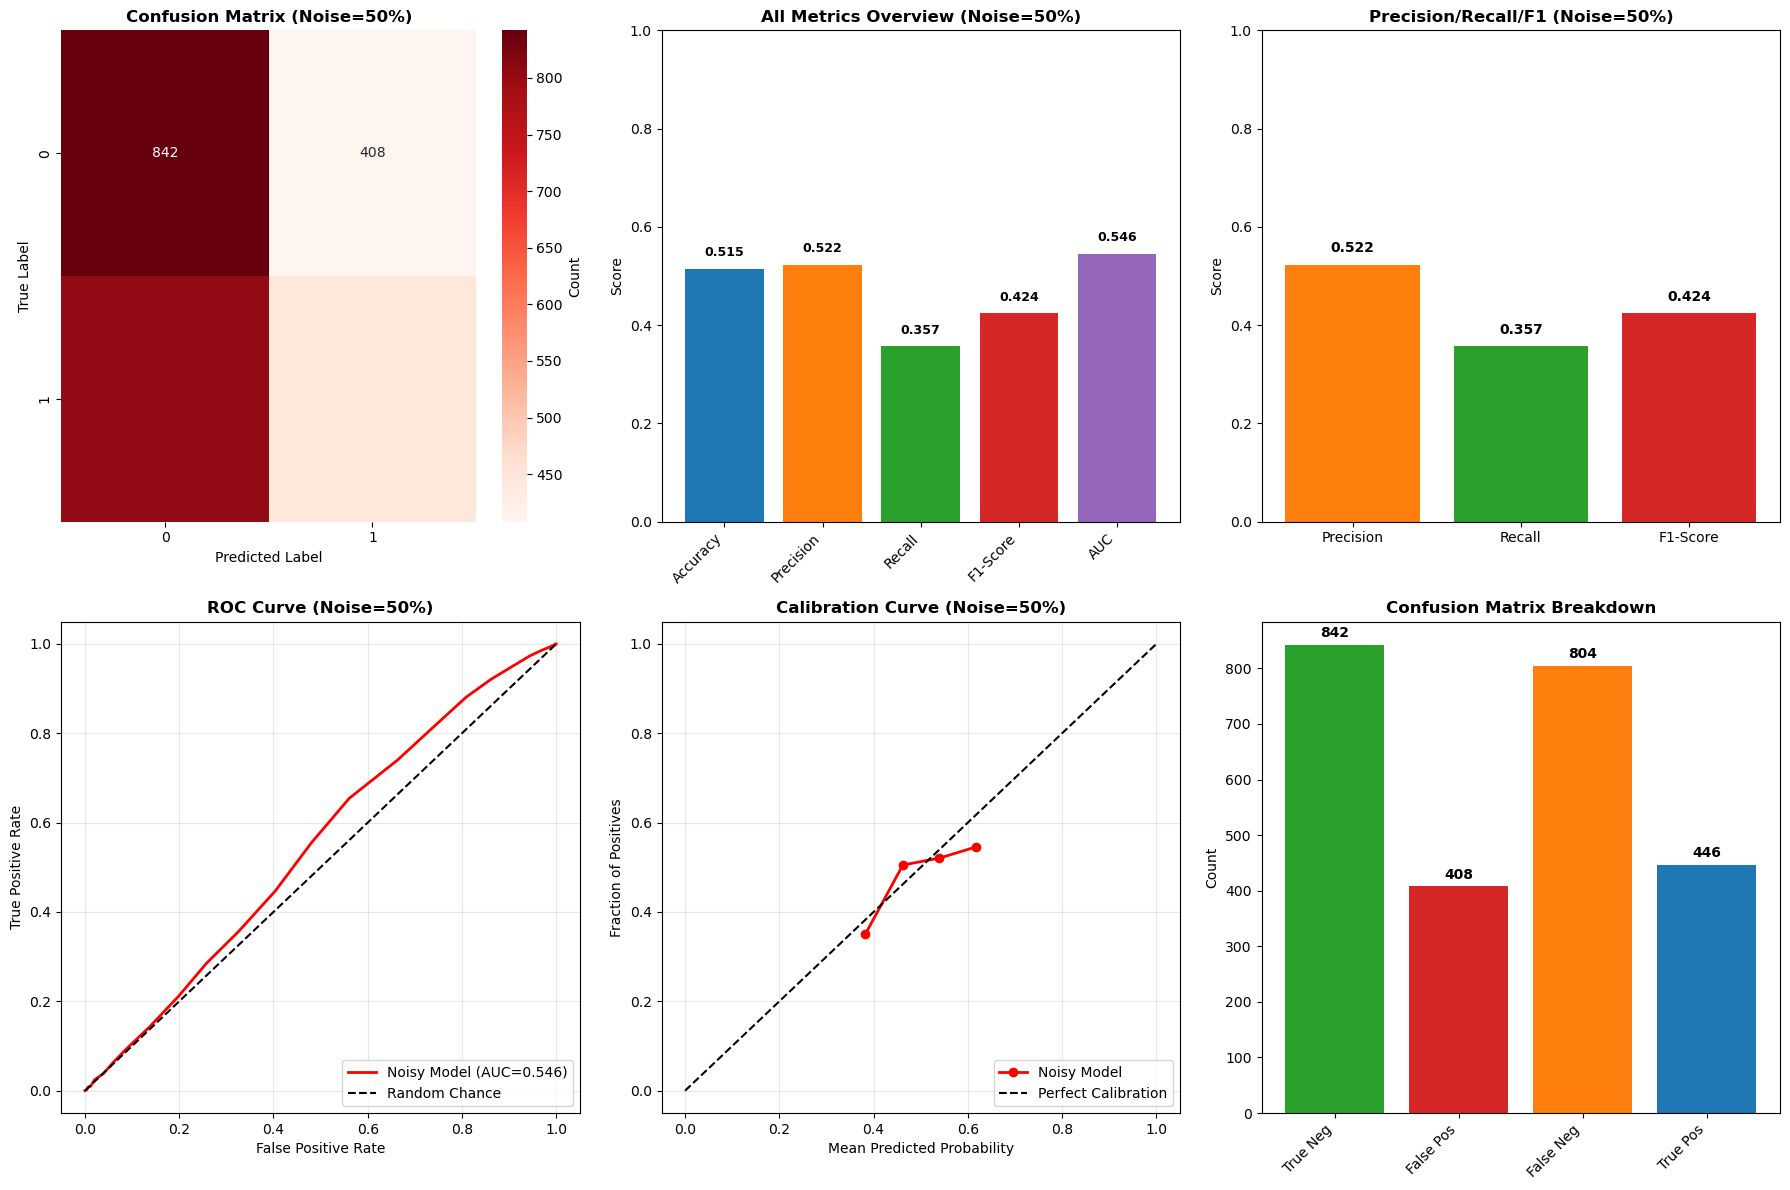


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.51      0.67      0.58      1250
     Default       0.52      0.36      0.42      1250

    accuracy                           0.52      2500
   macro avg       0.52      0.52      0.50      2500
weighted avg       0.52      0.52      0.50      2500



In [37]:
"""
KNN MODEL WITH SYMMETRIC NOISE (10%)
====================================
This script mirrors the Random Forest noise analysis but applies it to the KNN model.
- Introduces 10% symmetric noise by randomly flipping training labels (0->1 and 1->0)
- Trains KNN model on the noisy labels
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline KNN model
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_symmetric_noise(y, noise_rate, random_state=42):
    """
    Flips a fraction `noise_rate` of labels (symmetric noise).
    Randomly selects indices and flips 0->1 and 1->0.
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

p = 0.50  
y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)
print("Original label distribution:", np.bincount(y_train))
print("Noisy label distribution:", np.bincount(y_train_noisy))

# Train KNN model with noisy labels
knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k,  
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

# Make predictions
y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

# Calculate all metrics
acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store results
if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

# Print summary statistics
print(f"\n{'='*60}")
print(f"KNN WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# Create comprehensive visualization (matching Random Forest layout)
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 0 to 1, 10%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [3375 4125]
Flipped class 0 -> 1 at rate 0.1

KNN WITH 10% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.8032
Precision: 0.7328
Recall:    0.9544
F1 Score:  0.8290
AUC Score: 0.9278



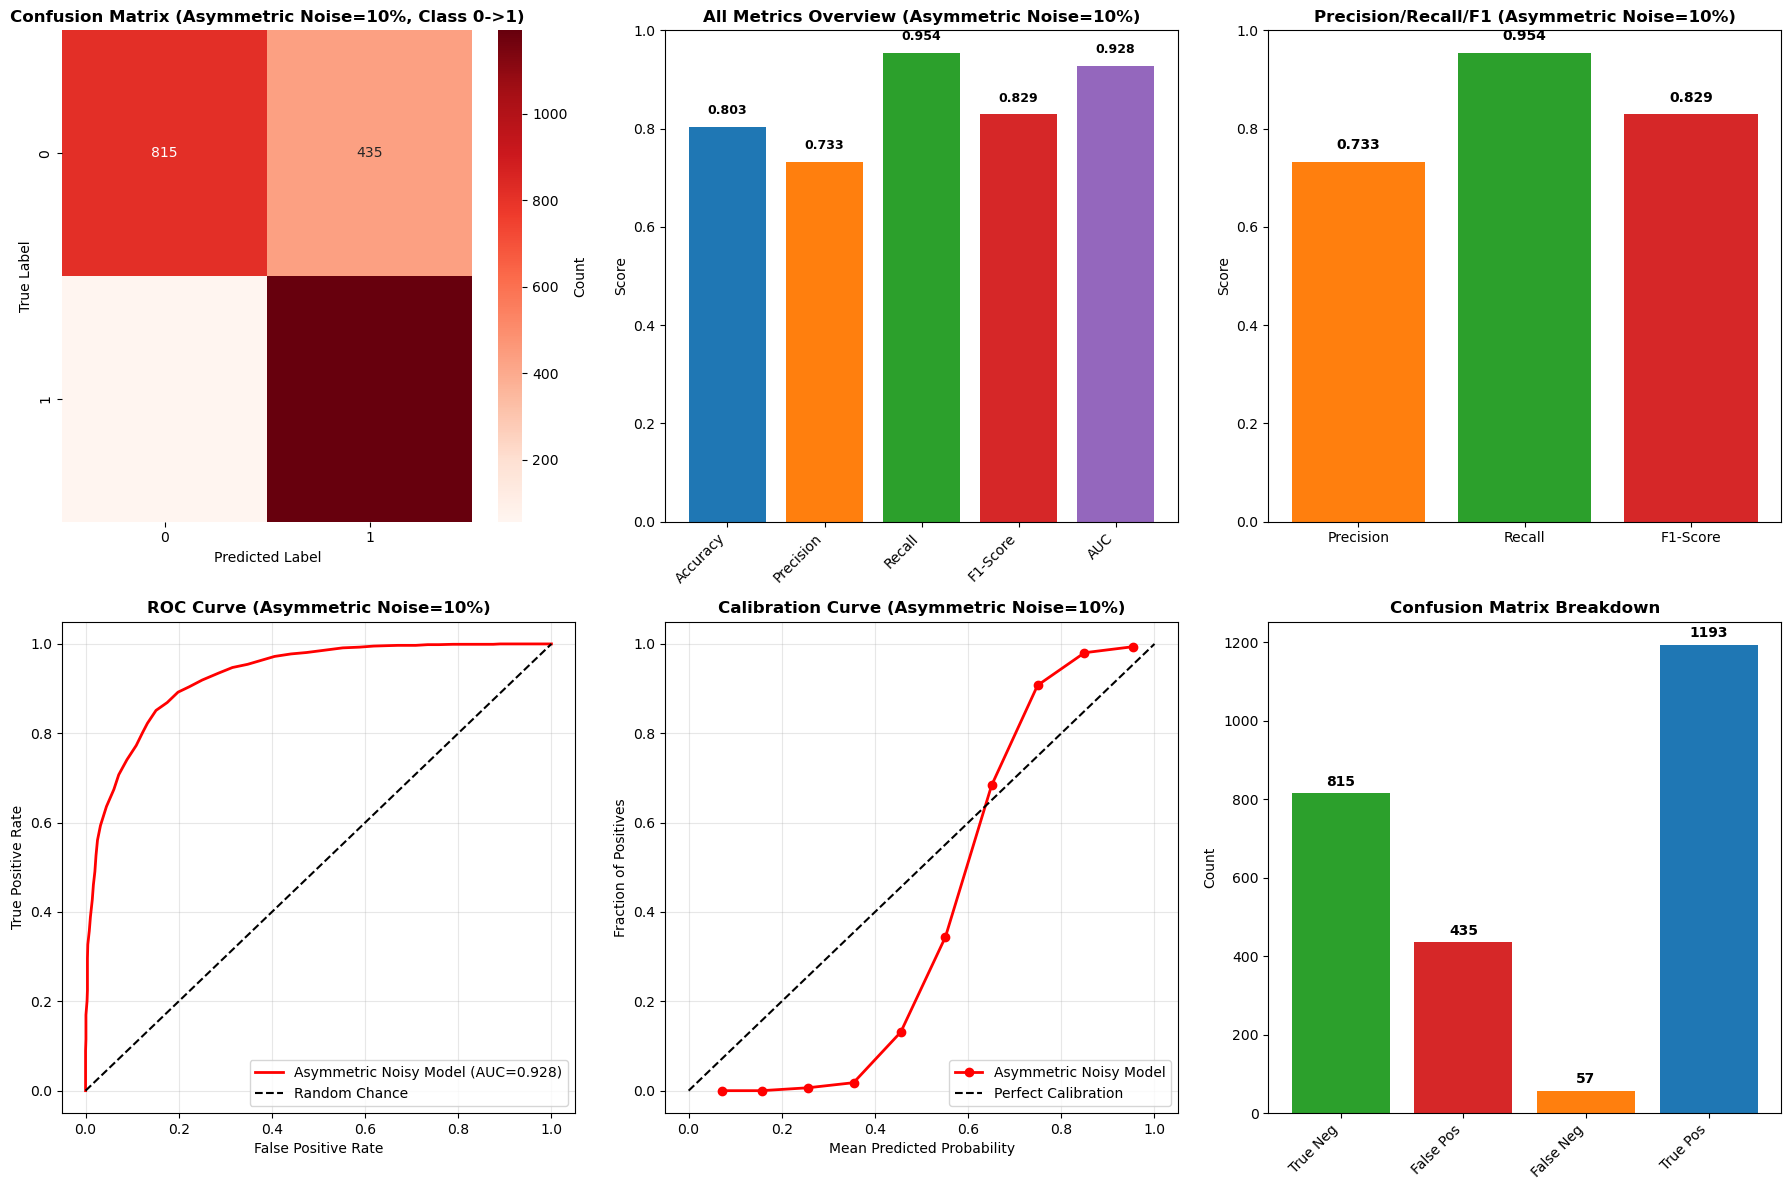


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.93      0.65      0.77      1250
     Default       0.73      0.95      0.83      1250

    accuracy                           0.80      2500
   macro avg       0.83      0.80      0.80      2500
weighted avg       0.83      0.80      0.80      2500



In [38]:
"""
KNN MODEL WITH ASYMMETRIC NOISE (Class 0 -> 1, 10%)
====================================================
This script mirrors the Random Forest asymmetric noise analysis but applies it to the KNN model.
- Introduces 10% asymmetric noise by flipping only Class 0 labels to Class 1 (0->1)
- This creates class imbalance and biased noise (unlike symmetric noise which flips both ways)
- Trains KNN model on the asymmetrically noisy labels
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline and symmetric noise models
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    """
    Flips a fraction of labels from one specific class to the other (asymmetric noise).
    Example: class_to_flip=0, flip_fraction=0.1 => 10% of Class 0 becomes Class 1.
    This differs from symmetric noise which flips both classes equally.
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    
    # Find all indices belonging to the class we want to flip
    idx = np.where(y == class_to_flip)[0]
    
    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)
    
    # Randomly select which samples to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    
    # Flip the selected labels to the opposite class
    y_noisy[flip_idx] = 1 - class_to_flip
    
    return y_noisy

# Set asymmetric noise parameters
class_to_flip = 0  # Flip Class 0 -> Class 1
p = 0.10         

# Inject asymmetric noise into training labels
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k, 
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"KNN WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")


fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 0 to 1, 20%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [3000 4500]
Flipped class 0 -> 1 at rate 0.2

KNN WITH 20% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.7252
Precision: 0.6479
Recall:    0.9864
F1 Score:  0.7821
AUC Score: 0.9229



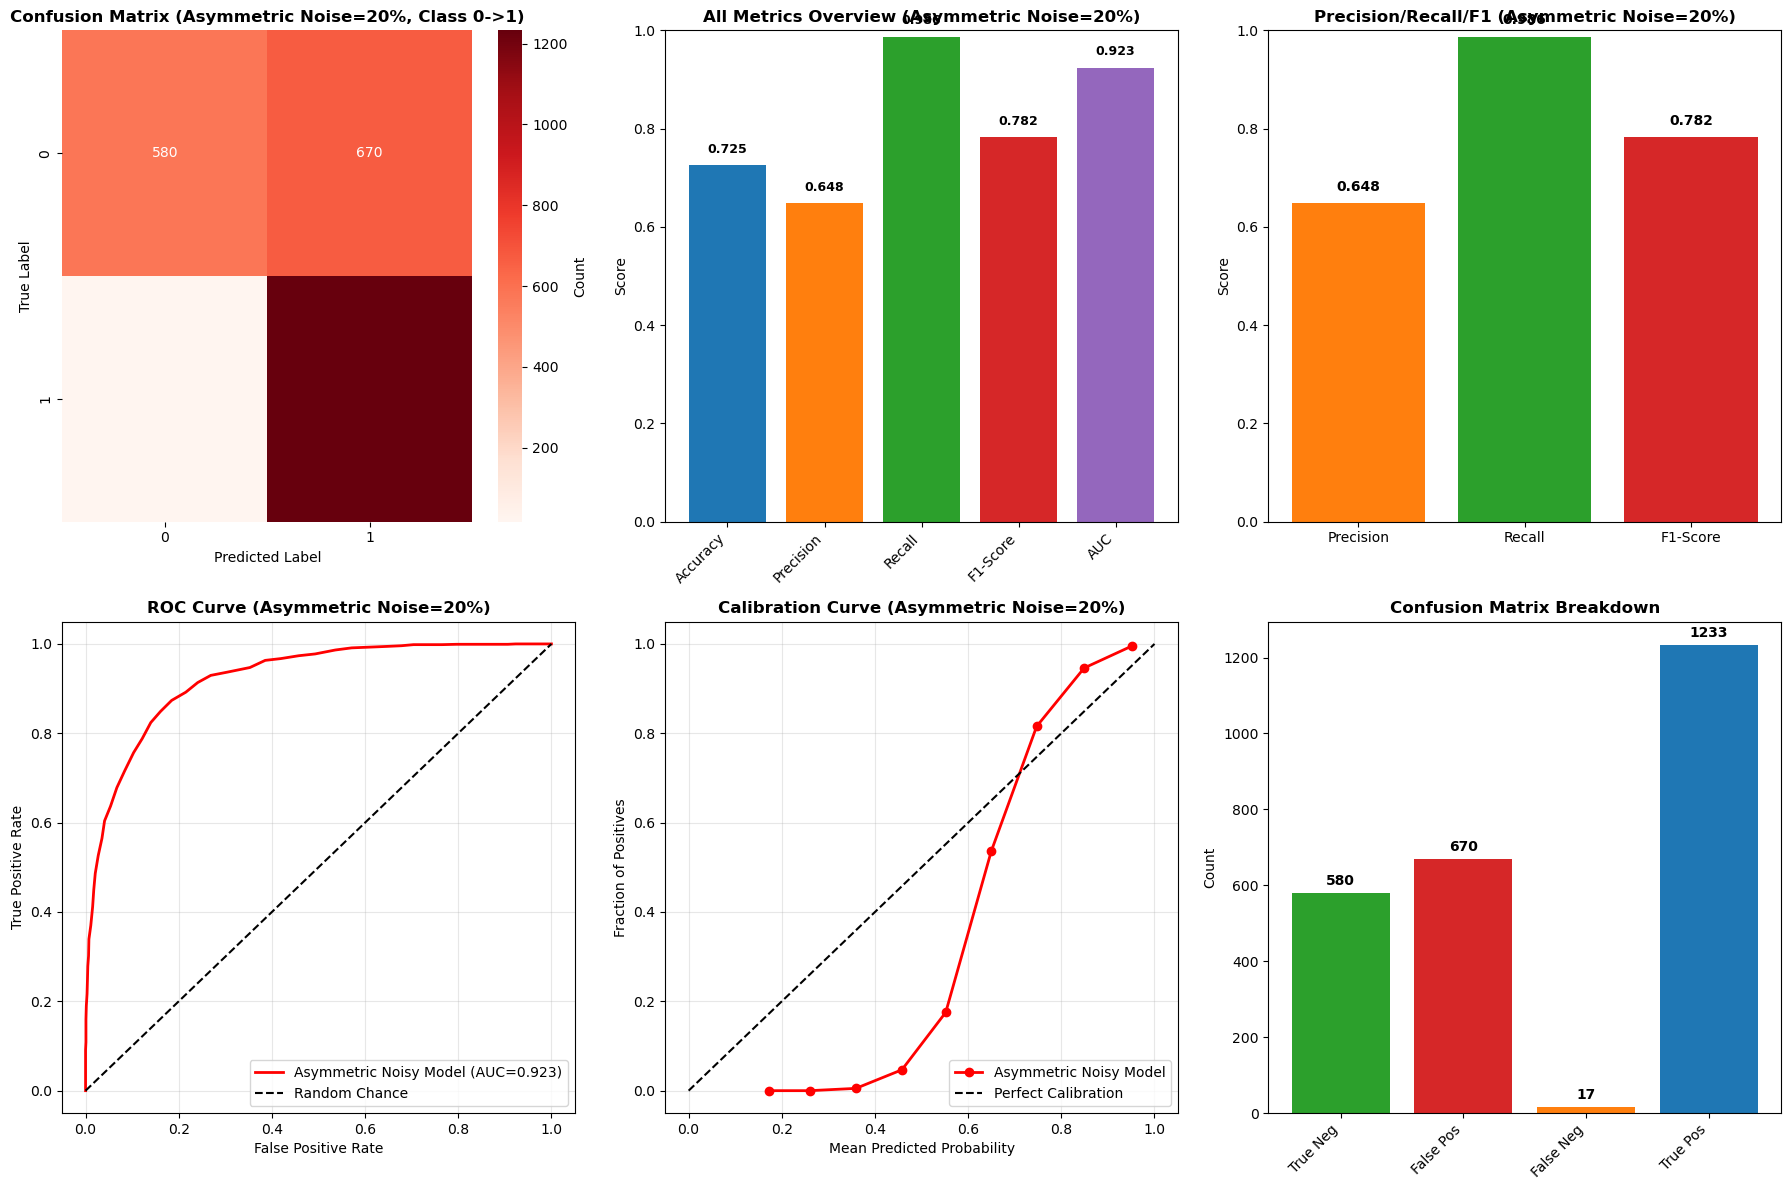


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.97      0.46      0.63      1250
     Default       0.65      0.99      0.78      1250

    accuracy                           0.73      2500
   macro avg       0.81      0.73      0.71      2500
weighted avg       0.81      0.73      0.71      2500



In [39]:
"""
KNN MODEL WITH ASYMMETRIC NOISE (Class 0 -> 1, 10%)
====================================================
This script mirrors the Random Forest asymmetric noise analysis but applies it to the KNN model.
- Introduces 10% asymmetric noise by flipping only Class 0 labels to Class 1 (0->1)
- This creates class imbalance and biased noise (unlike symmetric noise which flips both ways)
- Trains KNN model on the asymmetrically noisy labels
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline and symmetric noise models
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    """
    Flips a fraction of labels from one specific class to the other (asymmetric noise).
    Example: class_to_flip=0, flip_fraction=0.1 => 10% of Class 0 becomes Class 1.
    This differs from symmetric noise which flips both classes equally.
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    
    # Find all indices belonging to the class we want to flip
    idx = np.where(y == class_to_flip)[0]
    
    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)
    
    # Randomly select which samples to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    
    # Flip the selected labels to the opposite class
    y_noisy[flip_idx] = 1 - class_to_flip
    
    return y_noisy

# Set asymmetric noise parameters
class_to_flip = 0  # Flip Class 0 -> Class 1
p = 0.20         

# Inject asymmetric noise into training labels
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k, 
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"KNN WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")


fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 0 to 1, 33%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [2513 4987]
Flipped class 0 -> 1 at rate 0.33

KNN WITH 33% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.6192
Precision: 0.5679
Recall:    0.9976
F1 Score:  0.7237
AUC Score: 0.9185



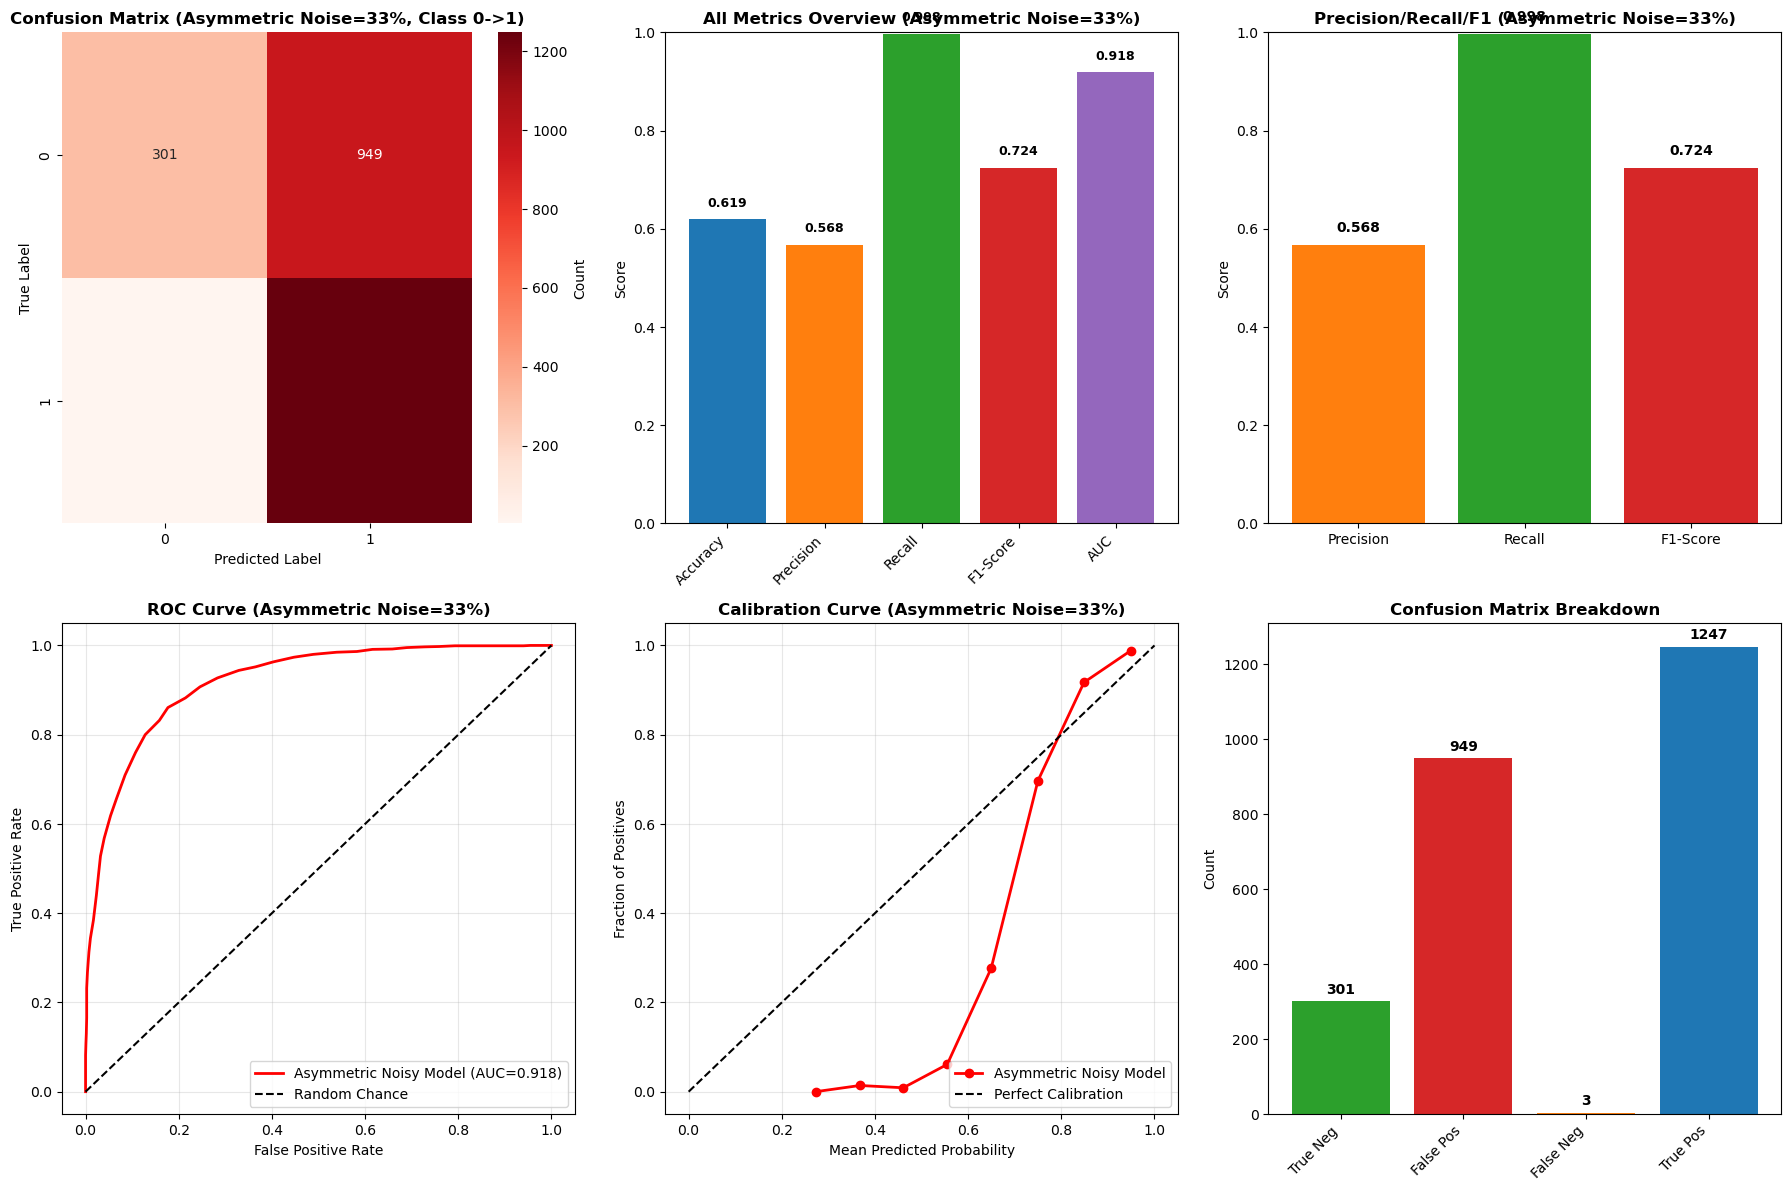


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.99      0.24      0.39      1250
     Default       0.57      1.00      0.72      1250

    accuracy                           0.62      2500
   macro avg       0.78      0.62      0.56      2500
weighted avg       0.78      0.62      0.56      2500



In [40]:
"""
KNN MODEL WITH ASYMMETRIC NOISE (Class 0 -> 1, 10%)
====================================================
This script mirrors the Random Forest asymmetric noise analysis but applies it to the KNN model.
- Introduces 10% asymmetric noise by flipping only Class 0 labels to Class 1 (0->1)
- This creates class imbalance and biased noise (unlike symmetric noise which flips both ways)
- Trains KNN model on the asymmetrically noisy labels
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline and symmetric noise models
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    """
    Flips a fraction of labels from one specific class to the other (asymmetric noise).
    Example: class_to_flip=0, flip_fraction=0.1 => 10% of Class 0 becomes Class 1.
    This differs from symmetric noise which flips both classes equally.
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    
    # Find all indices belonging to the class we want to flip
    idx = np.where(y == class_to_flip)[0]
    
    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)
    
    # Randomly select which samples to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    
    # Flip the selected labels to the opposite class
    y_noisy[flip_idx] = 1 - class_to_flip
    
    return y_noisy

# Set asymmetric noise parameters
class_to_flip = 0  # Flip Class 0 -> Class 1
p = 0.33         

# Inject asymmetric noise into training labels
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k, 
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"KNN WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")


fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 0 to 1, 50%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [1875 5625]
Flipped class 0 -> 1 at rate 0.5

KNN WITH 50% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.5108
Precision: 0.5055
Recall:    1.0000
F1 Score:  0.6715
AUC Score: 0.9073



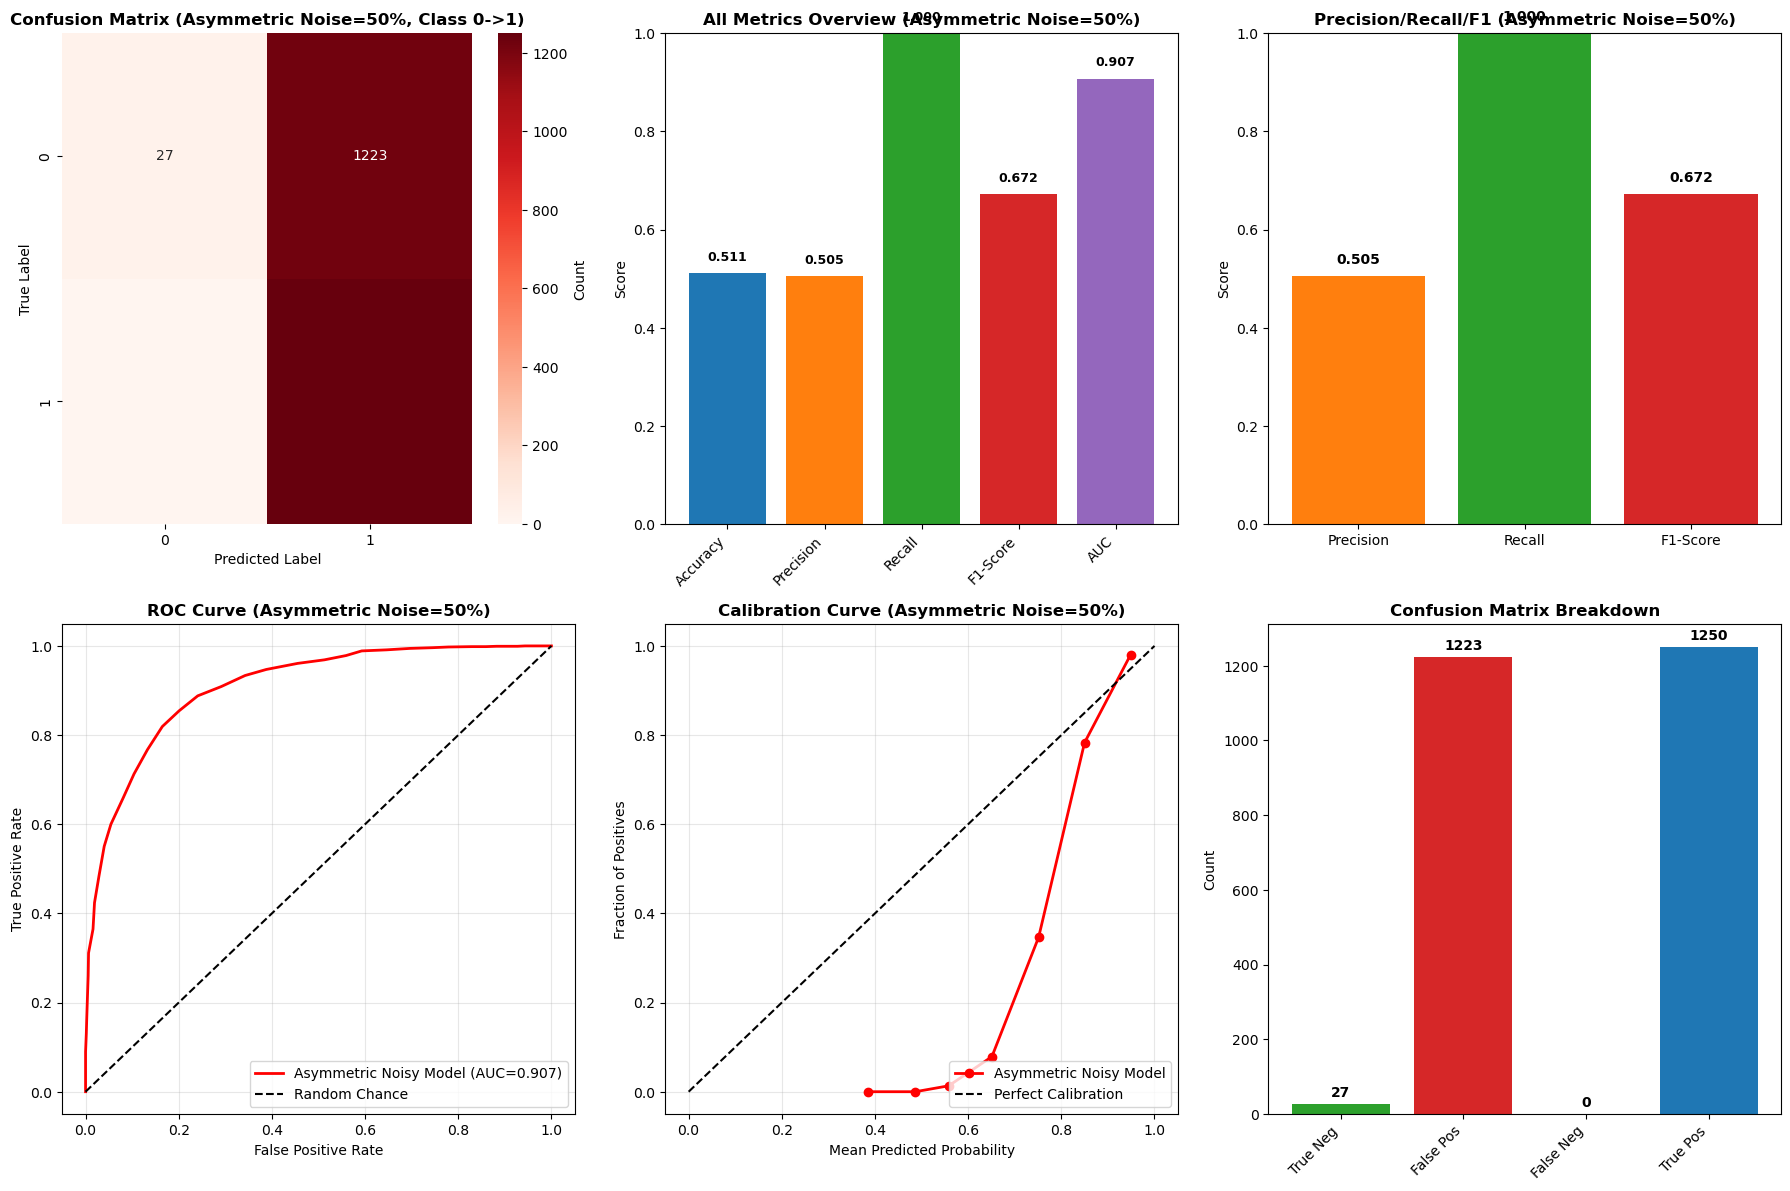


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       1.00      0.02      0.04      1250
     Default       0.51      1.00      0.67      1250

    accuracy                           0.51      2500
   macro avg       0.75      0.51      0.36      2500
weighted avg       0.75      0.51      0.36      2500



In [41]:
"""
KNN MODEL WITH ASYMMETRIC NOISE (Class 0 -> 1, 10%)
====================================================
This script mirrors the Random Forest asymmetric noise analysis but applies it to the KNN model.
- Introduces 10% asymmetric noise by flipping only Class 0 labels to Class 1 (0->1)
- This creates class imbalance and biased noise (unlike symmetric noise which flips both ways)
- Trains KNN model on the asymmetrically noisy labels
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline and symmetric noise models
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    """
    Flips a fraction of labels from one specific class to the other (asymmetric noise).
    Example: class_to_flip=0, flip_fraction=0.1 => 10% of Class 0 becomes Class 1.
    This differs from symmetric noise which flips both classes equally.
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    
    # Find all indices belonging to the class we want to flip
    idx = np.where(y == class_to_flip)[0]
    
    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)
    
    # Randomly select which samples to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    
    # Flip the selected labels to the opposite class
    y_noisy[flip_idx] = 1 - class_to_flip
    
    return y_noisy

# Set asymmetric noise parameters
class_to_flip = 0  # Flip Class 0 -> Class 1
p = 0.50         

# Inject asymmetric noise into training labels
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k, 
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"KNN WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")


fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 1 to 0, 10%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [4125 3375]
Flipped class 1 -> 0 at rate 0.1

KNN WITH 10% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.8396
Precision: 0.8582
Recall:    0.8136
F1 Score:  0.8353
AUC Score: 0.9294



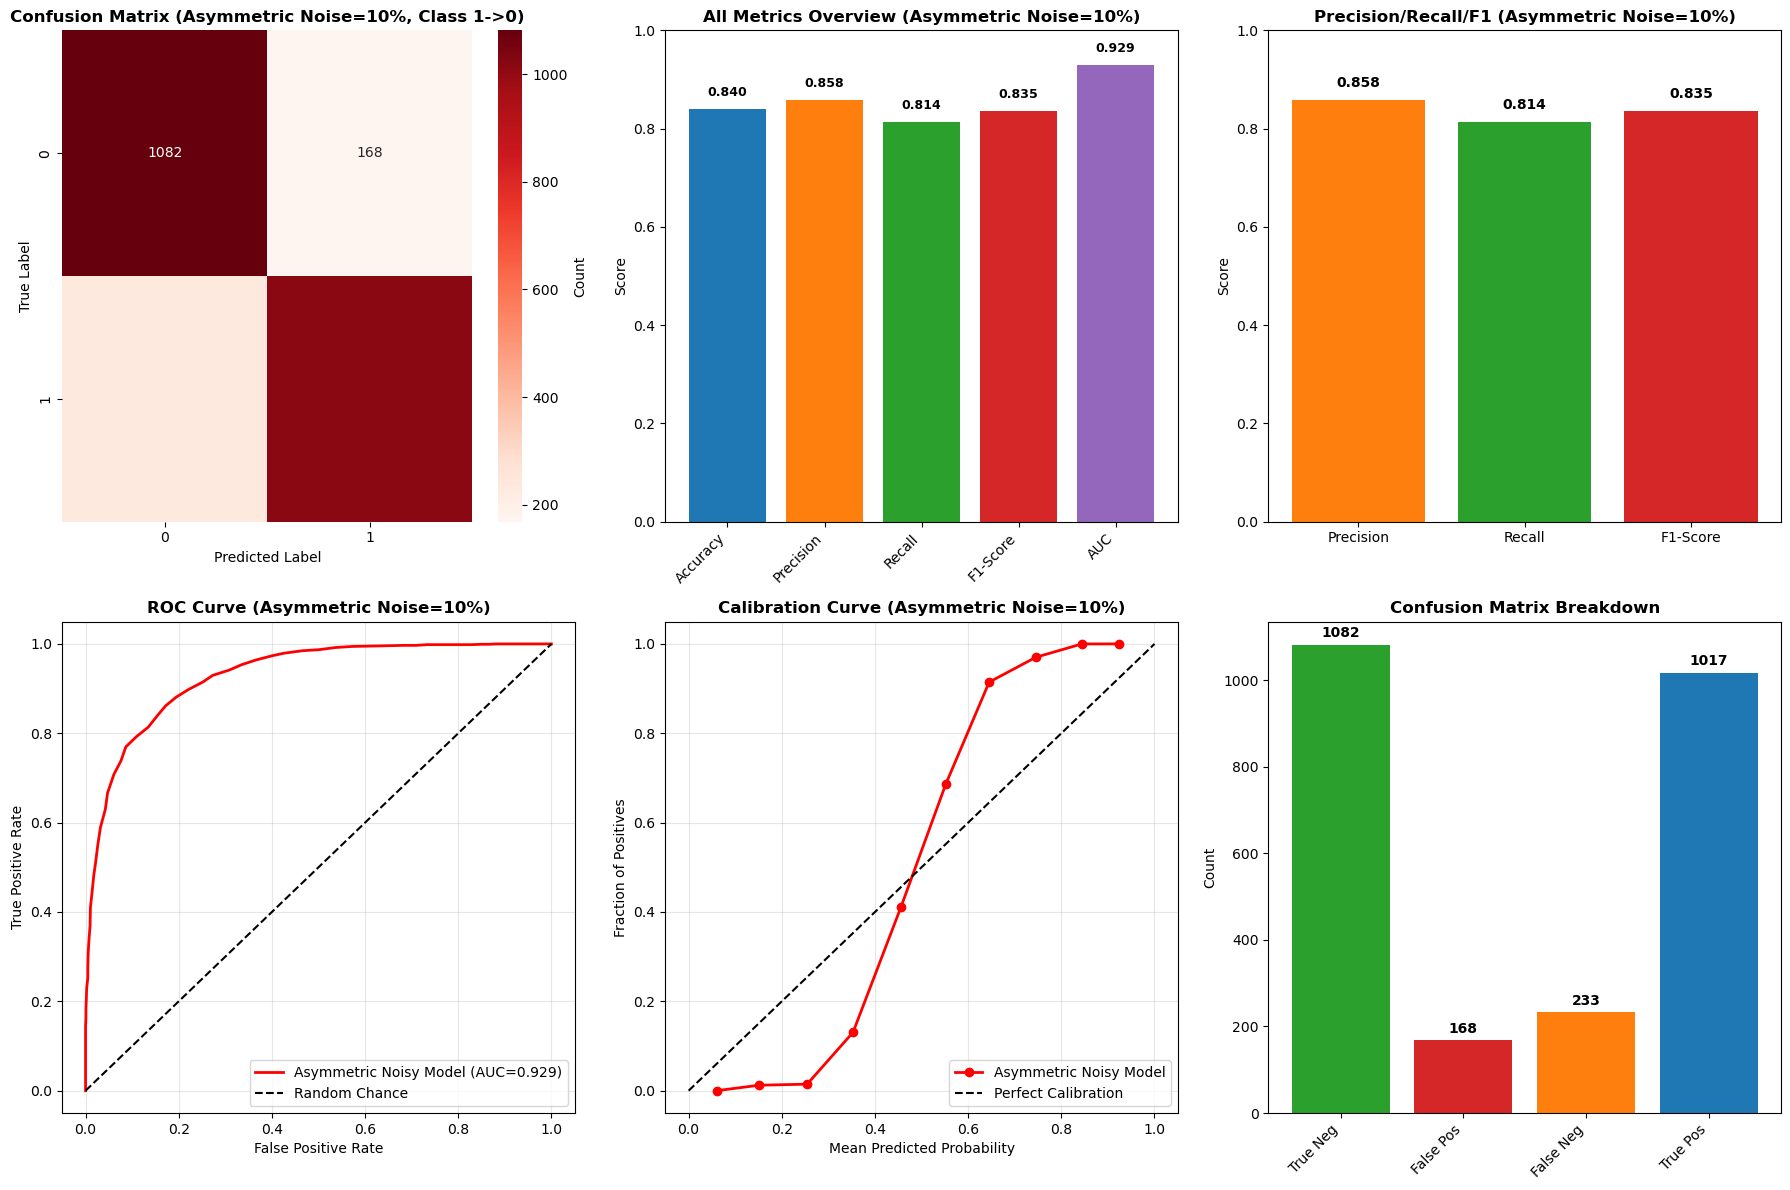


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.82      0.87      0.84      1250
     Default       0.86      0.81      0.84      1250

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500



In [42]:
"""
KNN MODEL WITH ASYMMETRIC NOISE (Class 0 -> 1, 10%)
====================================================
This script mirrors the Random Forest asymmetric noise analysis but applies it to the KNN model.
- Introduces 10% asymmetric noise by flipping only Class 0 labels to Class 1 (0->1)
- This creates class imbalance and biased noise (unlike symmetric noise which flips both ways)
- Trains KNN model on the asymmetrically noisy labels
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline and symmetric noise models
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    """
    Flips a fraction of labels from one specific class to the other (asymmetric noise).
    Example: class_to_flip=0, flip_fraction=0.1 => 10% of Class 0 becomes Class 1.
    This differs from symmetric noise which flips both classes equally.
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    
    # Find all indices belonging to the class we want to flip
    idx = np.where(y == class_to_flip)[0]
    
    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)
    
    # Randomly select which samples to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    
    # Flip the selected labels to the opposite class
    y_noisy[flip_idx] = 1 - class_to_flip
    
    return y_noisy

# Set asymmetric noise parameters
class_to_flip = 1  # Flip Class 0 -> Class 1
p = 0.10         

# Inject asymmetric noise into training labels
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k, 
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"KNN WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")


fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 1 to 0, 20%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [4500 3000]
Flipped class 1 -> 0 at rate 0.2

KNN WITH 20% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.8096
Precision: 0.9262
Recall:    0.6728
F1 Score:  0.7794
AUC Score: 0.9275



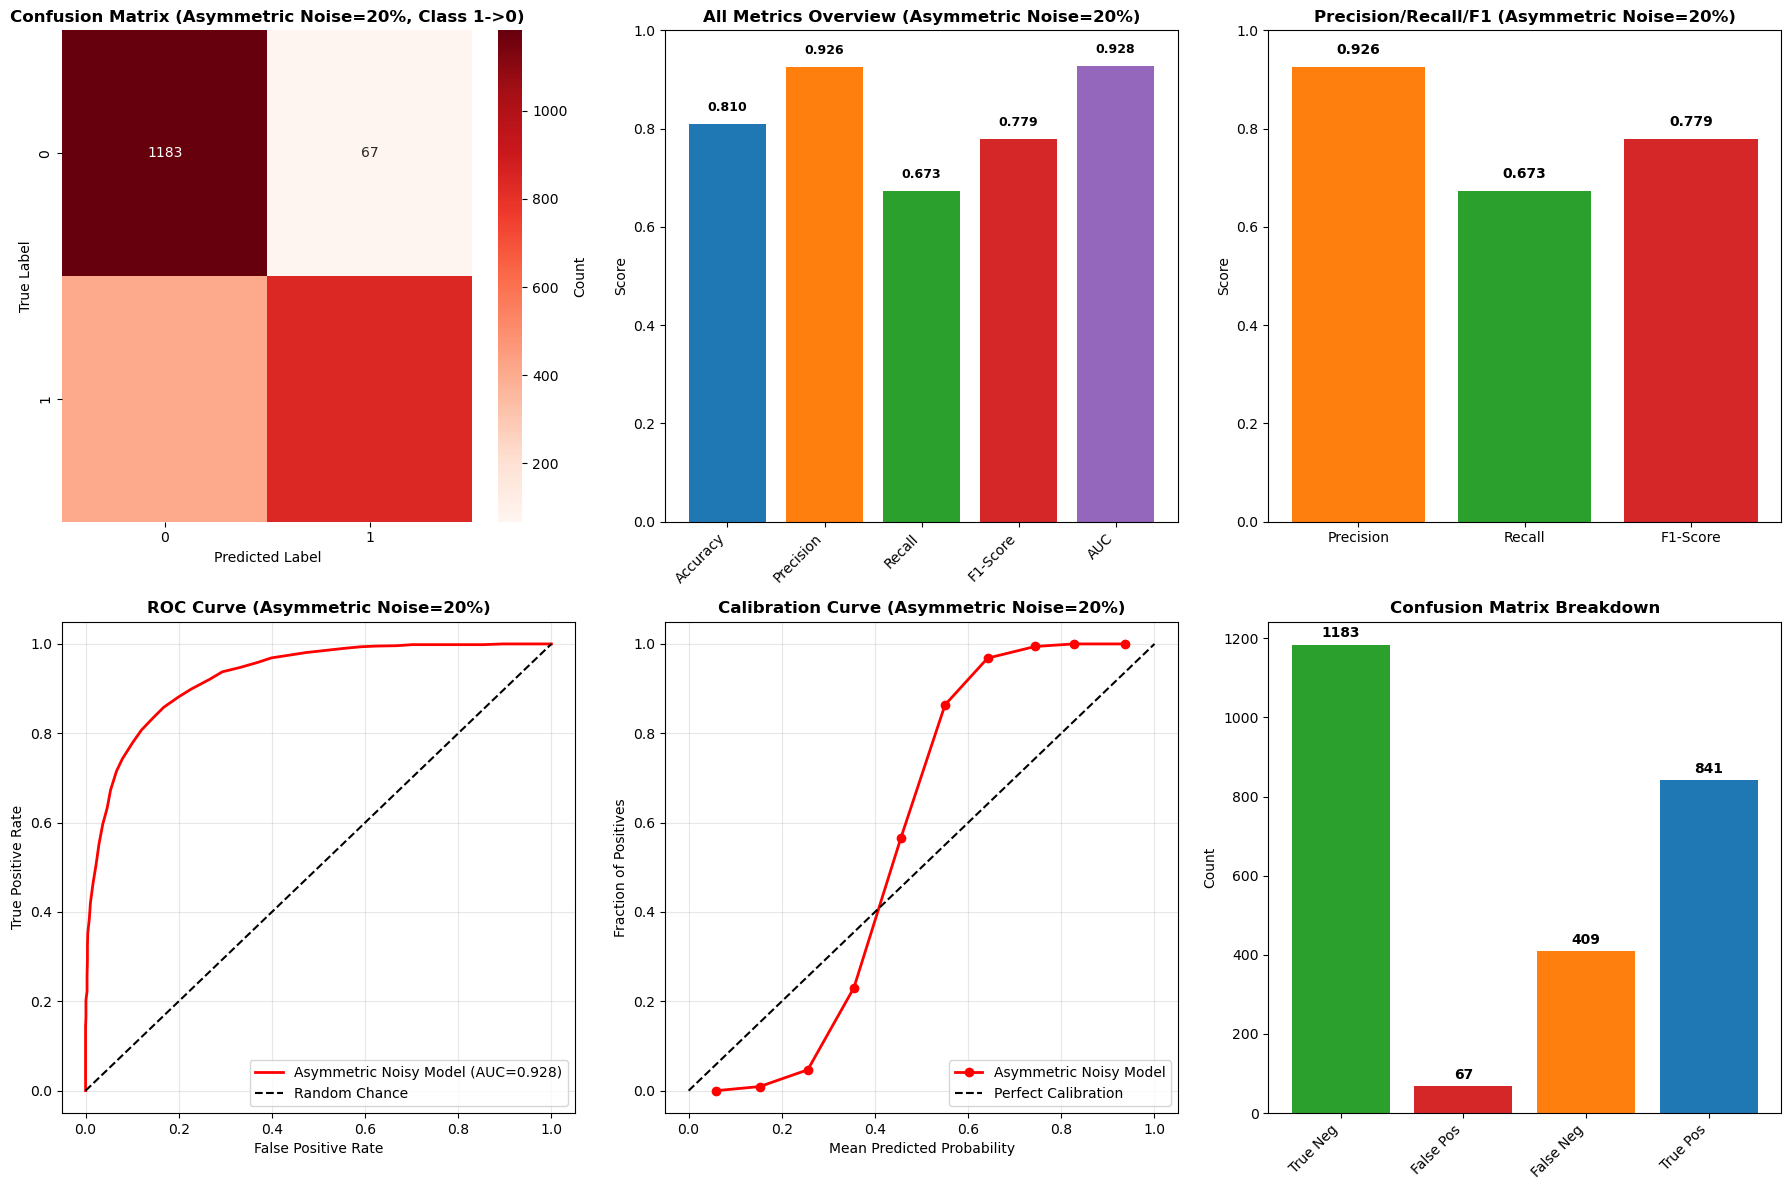


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.74      0.95      0.83      1250
     Default       0.93      0.67      0.78      1250

    accuracy                           0.81      2500
   macro avg       0.83      0.81      0.81      2500
weighted avg       0.83      0.81      0.81      2500



In [43]:
"""
KNN MODEL WITH ASYMMETRIC NOISE (Class 0 -> 1, 10%)
====================================================
This script mirrors the Random Forest asymmetric noise analysis but applies it to the KNN model.
- Introduces 10% asymmetric noise by flipping only Class 0 labels to Class 1 (0->1)
- This creates class imbalance and biased noise (unlike symmetric noise which flips both ways)
- Trains KNN model on the asymmetrically noisy labels
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline and symmetric noise models
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    """
    Flips a fraction of labels from one specific class to the other (asymmetric noise).
    Example: class_to_flip=0, flip_fraction=0.1 => 10% of Class 0 becomes Class 1.
    This differs from symmetric noise which flips both classes equally.
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    
    # Find all indices belonging to the class we want to flip
    idx = np.where(y == class_to_flip)[0]
    
    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)
    
    # Randomly select which samples to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    
    # Flip the selected labels to the opposite class
    y_noisy[flip_idx] = 1 - class_to_flip
    
    return y_noisy

# Set asymmetric noise parameters
class_to_flip = 1  # Flip Class 0 -> Class 1
p = 0.20         

# Inject asymmetric noise into training labels
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k, 
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"KNN WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")


fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 1 to 0, 33%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [4987 2513]
Flipped class 1 -> 0 at rate 0.33

KNN WITH 33% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.6696
Precision: 0.9818
Recall:    0.3456
F1 Score:  0.5112
AUC Score: 0.9171



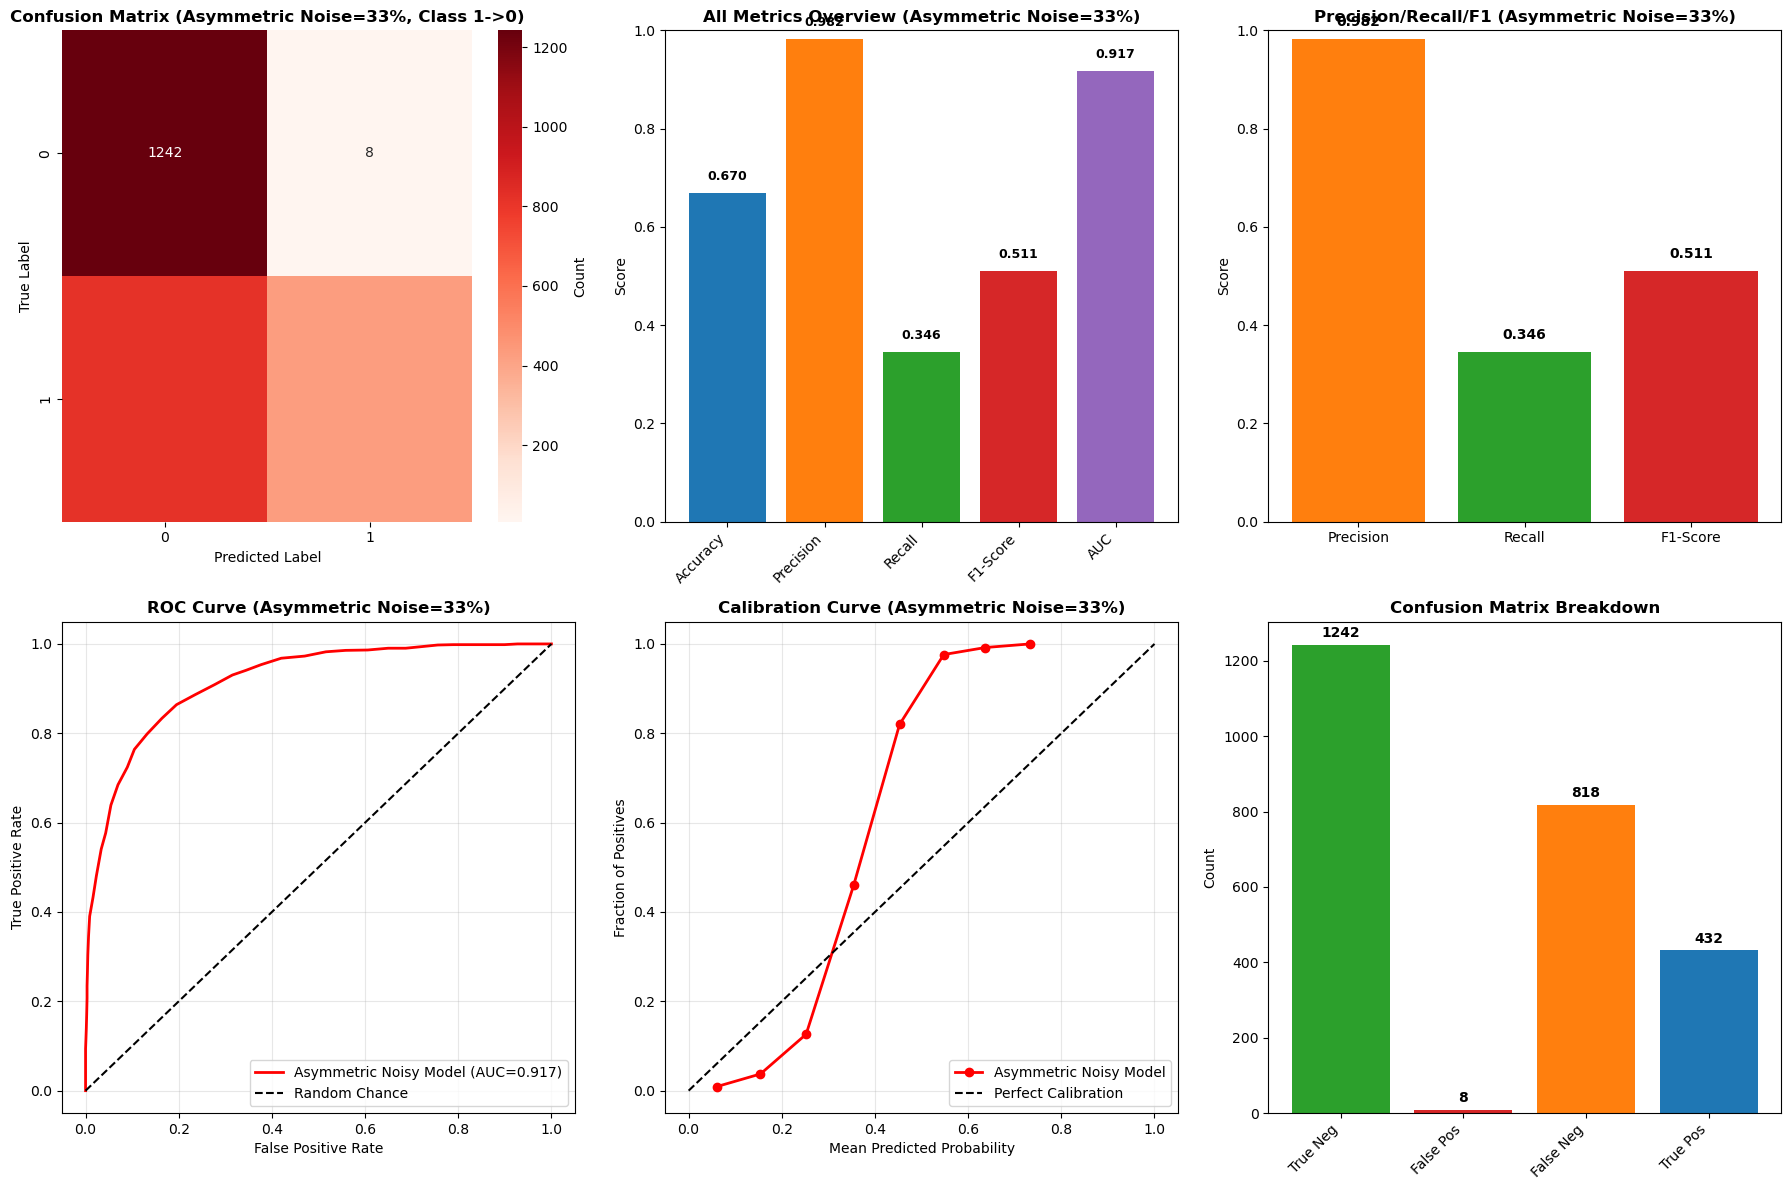


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.60      0.99      0.75      1250
     Default       0.98      0.35      0.51      1250

    accuracy                           0.67      2500
   macro avg       0.79      0.67      0.63      2500
weighted avg       0.79      0.67      0.63      2500



In [44]:
"""
KNN MODEL WITH ASYMMETRIC NOISE (Class 0 -> 1, 10%)
====================================================
This script mirrors the Random Forest asymmetric noise analysis but applies it to the KNN model.
- Introduces 10% asymmetric noise by flipping only Class 0 labels to Class 1 (0->1)
- This creates class imbalance and biased noise (unlike symmetric noise which flips both ways)
- Trains KNN model on the asymmetrically noisy labels
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline and symmetric noise models
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    """
    Flips a fraction of labels from one specific class to the other (asymmetric noise).
    Example: class_to_flip=0, flip_fraction=0.1 => 10% of Class 0 becomes Class 1.
    This differs from symmetric noise which flips both classes equally.
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    
    # Find all indices belonging to the class we want to flip
    idx = np.where(y == class_to_flip)[0]
    
    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)
    
    # Randomly select which samples to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    
    # Flip the selected labels to the opposite class
    y_noisy[flip_idx] = 1 - class_to_flip
    
    return y_noisy

# Set asymmetric noise parameters
class_to_flip = 1  # Flip Class 0 -> Class 1
p = 0.33         

# Inject asymmetric noise into training labels
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k, 
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"KNN WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")


fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 1 to 0, 50%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [5625 1875]
Flipped class 1 -> 0 at rate 0.5

KNN WITH 50% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.5144
Precision: 1.0000
Recall:    0.0288
F1 Score:  0.0560
AUC Score: 0.8998



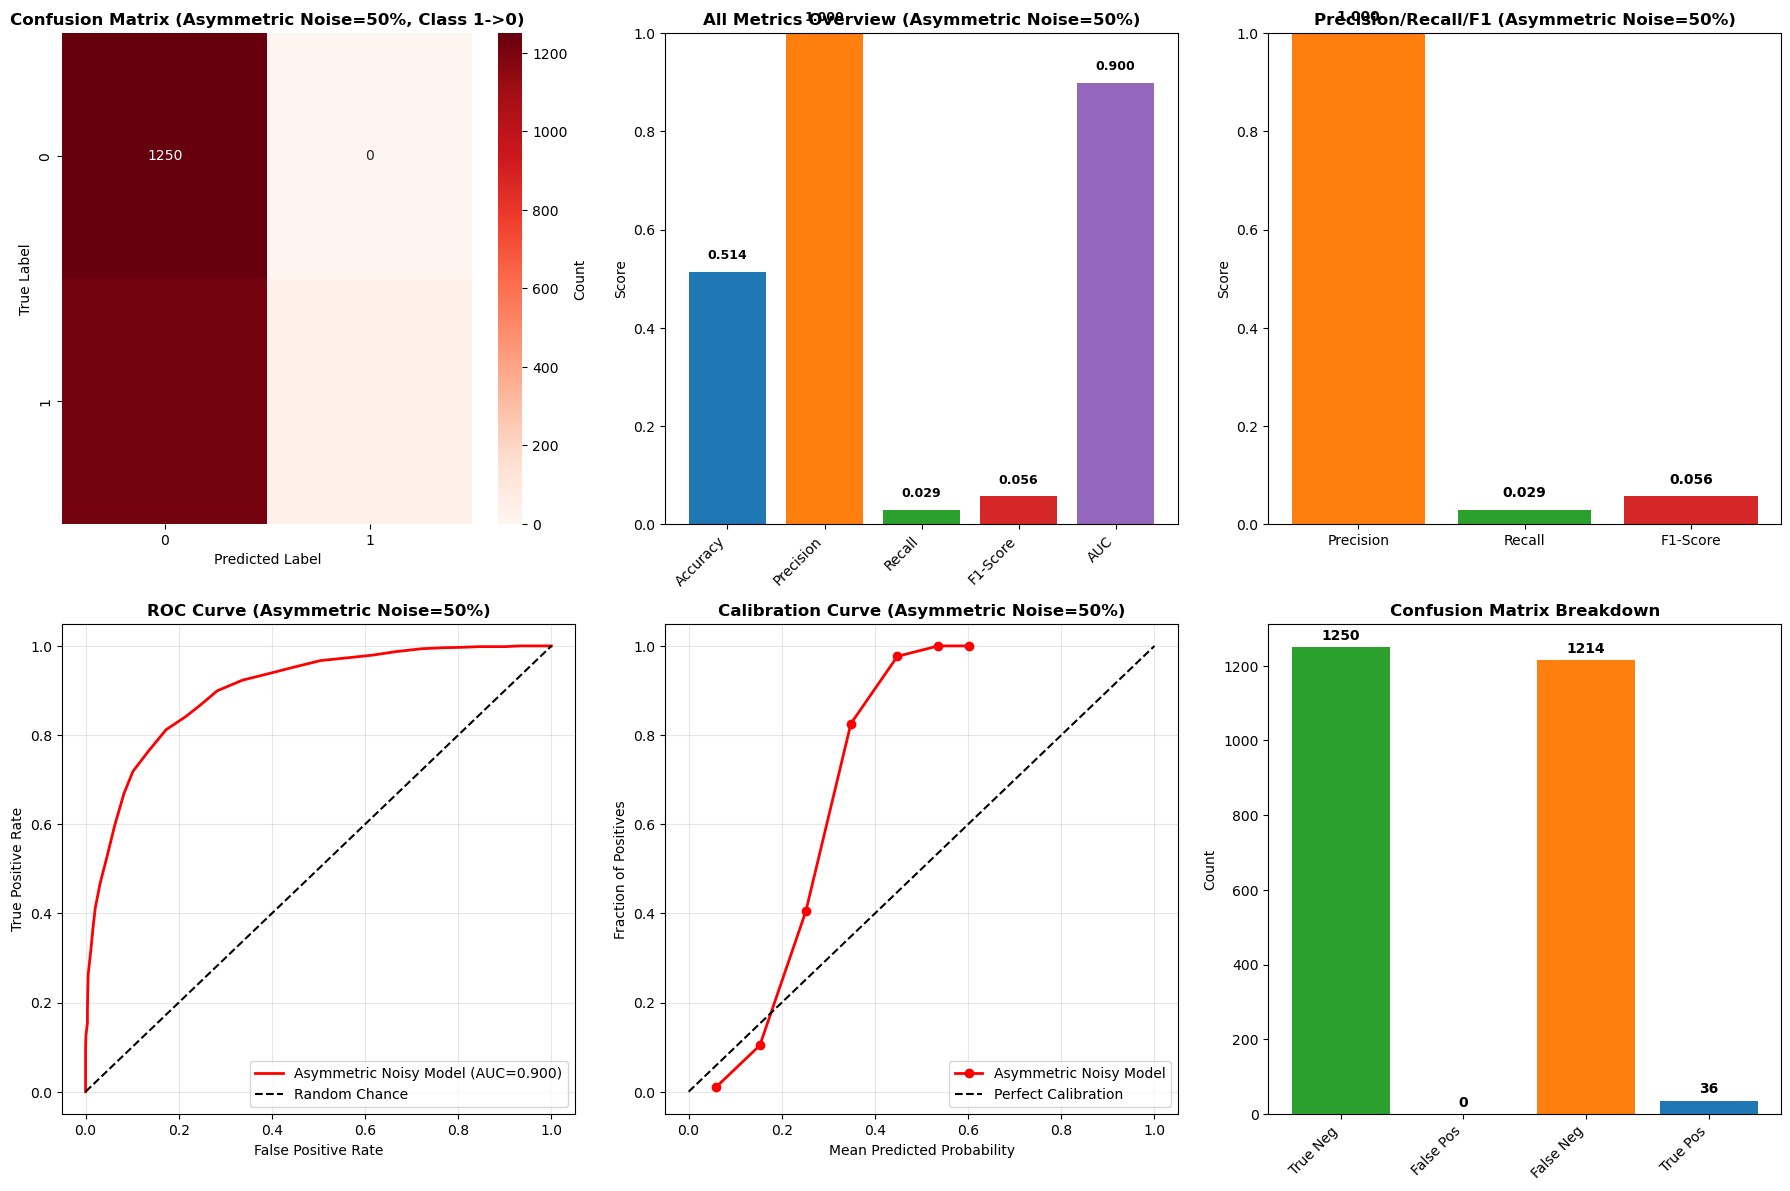


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.51      1.00      0.67      1250
     Default       1.00      0.03      0.06      1250

    accuracy                           0.51      2500
   macro avg       0.75      0.51      0.36      2500
weighted avg       0.75      0.51      0.36      2500



In [45]:
"""
KNN MODEL WITH ASYMMETRIC NOISE (Class 0 -> 1, 10%)
====================================================
This script mirrors the Random Forest asymmetric noise analysis but applies it to the KNN model.
- Introduces 10% asymmetric noise by flipping only Class 0 labels to Class 1 (0->1)
- This creates class imbalance and biased noise (unlike symmetric noise which flips both ways)
- Trains KNN model on the asymmetrically noisy labels
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline and symmetric noise models
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    """
    Flips a fraction of labels from one specific class to the other (asymmetric noise).
    Example: class_to_flip=0, flip_fraction=0.1 => 10% of Class 0 becomes Class 1.
    This differs from symmetric noise which flips both classes equally.
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    
    # Find all indices belonging to the class we want to flip
    idx = np.where(y == class_to_flip)[0]
    
    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)
    
    # Randomly select which samples to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    
    # Flip the selected labels to the opposite class
    y_noisy[flip_idx] = 1 - class_to_flip
    
    return y_noisy

# Set asymmetric noise parameters
class_to_flip = 1  # Flip Class 0 -> Class 1
p = 0.50         

# Inject asymmetric noise into training labels
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k, 
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"KNN WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")


fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 4 = Label Noise via Confusion Matrix (Transition Matrix Noise) 0->1(20%) and 1->0(5%)

Original label distribution: [3750 3750]
Confusion matrix noisy label distribution: [3187 4313]
Noise rates: 0→1=0.2, 1→0=0.05

KNN WITH CONFUSION MATRIX NOISE (0→1=0.2, 1→0=0.05)
Accuracy:  0.7524
Precision: 0.6748
Recall:    0.9744
F1 Score:  0.7974
AUC Score: 0.9204



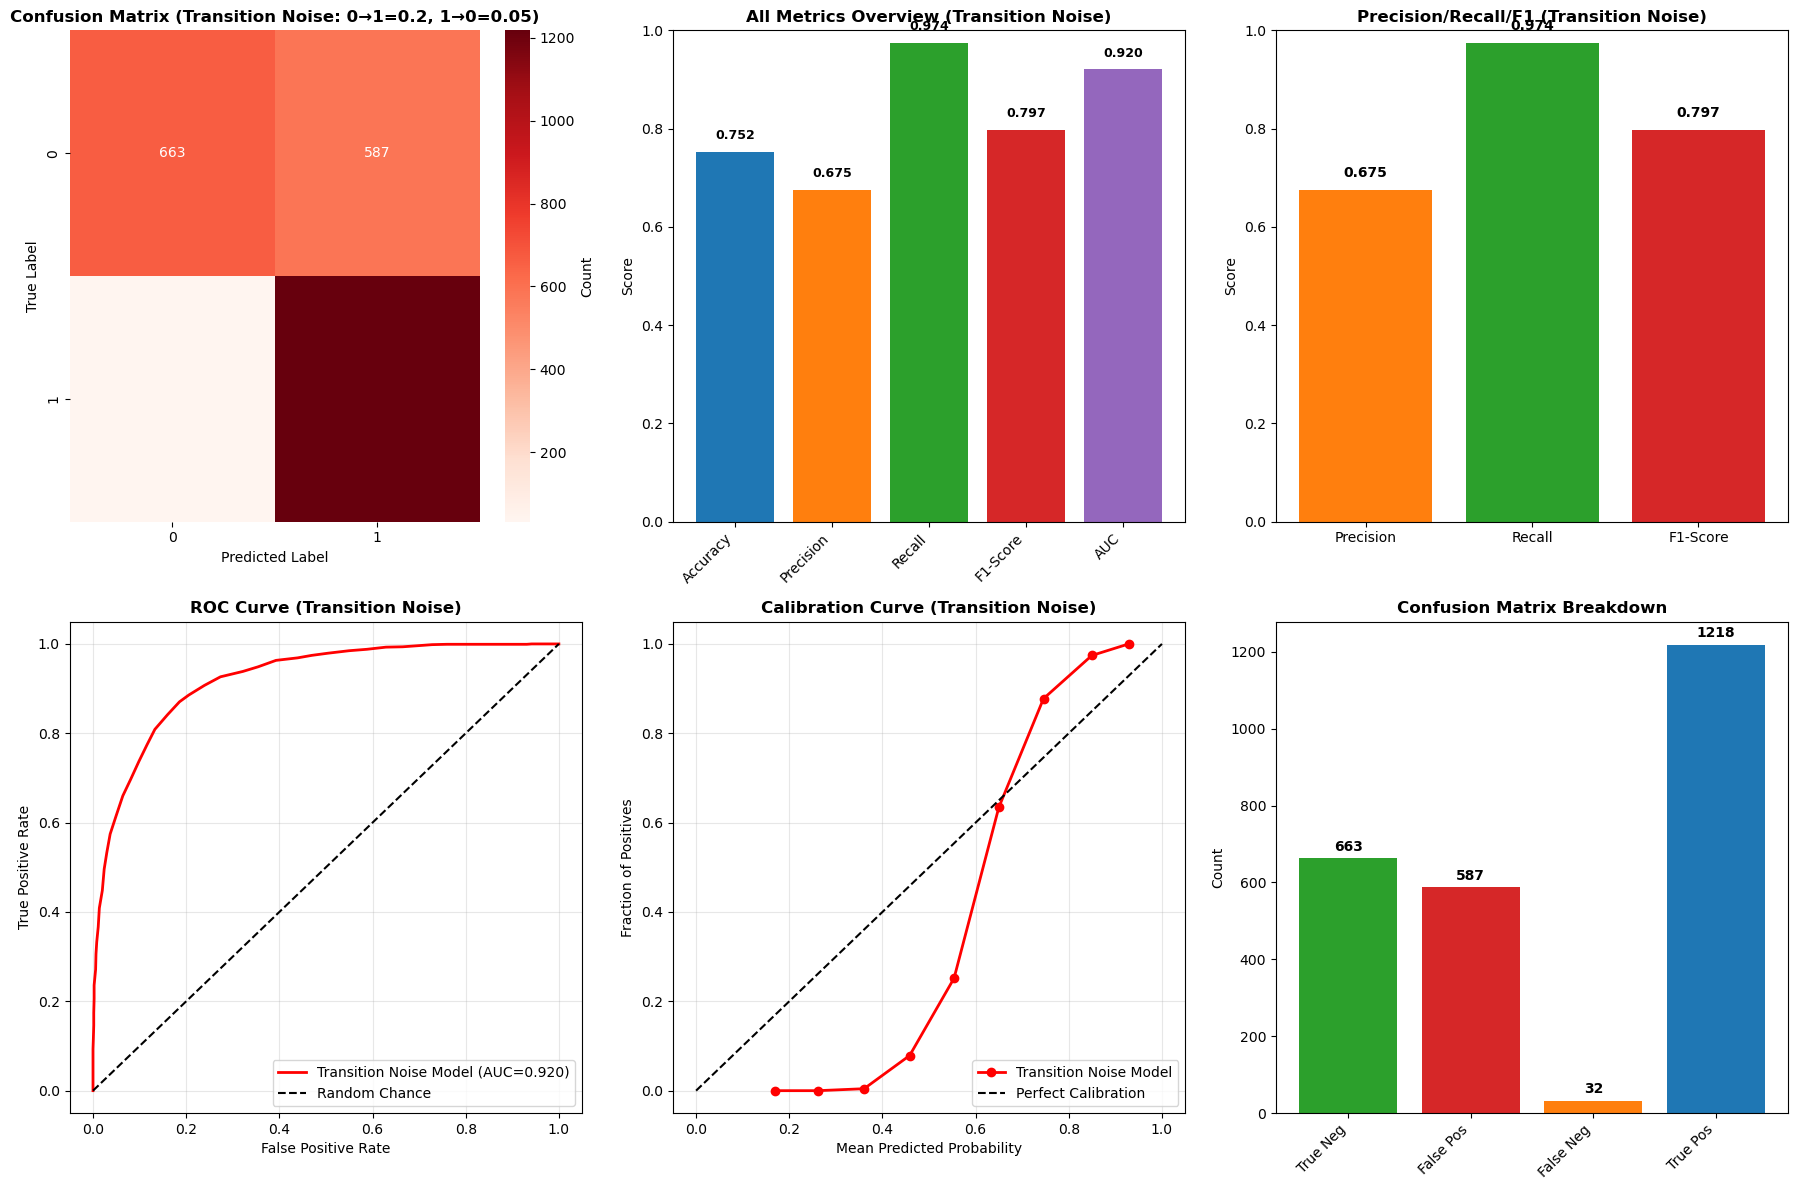


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.95      0.53      0.68      1250
     Default       0.67      0.97      0.80      1250

    accuracy                           0.75      2500
   macro avg       0.81      0.75      0.74      2500
weighted avg       0.81      0.75      0.74      2500



In [46]:
"""
KNN MODEL WITH CONFUSION MATRIX NOISE (Transition Matrix: 0→1=20%, 1→0=5%)
===========================================================================
This script mirrors the Random Forest confusion matrix noise analysis but applies it to the KNN model.
- Introduces label noise via transition matrix with two independent flip probabilities:
  * eta_01 = 20%: Probability of flipping Class 0 → Class 1
  * eta_10 = 5%:  Probability of flipping Class 1 → Class 0
- This creates asymmetric bidirectional noise (different flip rates for each class)
- Differs from simple asymmetric noise by allowing flips in BOTH directions simultaneously
- Trains KNN model on the noisy labels with confusion matrix noise
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline and other noise models
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    """
    Applies label noise via transition matrix (confusion matrix noise).
    
    This method flips labels based on a noise transition matrix:
    - eta_01: Probability that a true Class 0 label is flipped to Class 1
    - eta_10: Probability that a true Class 1 label is flipped to Class 0
    
    Unlike symmetric or simple asymmetric noise, this allows independent 
    control of flip rates in both directions.
    
    Args:
        y: True labels array
        eta_01: Flip rate for 0→1 (e.g., 0.20 = 20% of 0s become 1s)
        eta_10: Flip rate for 1→0 (e.g., 0.05 = 5% of 1s become 0s)
        random_state: Random seed for reproducibility
    
    Returns:
        y_noisy: Labels with confusion matrix noise applied
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    
    # Flip Class 0 → Class 1
    idx0 = np.where(y == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1
    
    # Flip Class 1 → Class 0
    idx1 = np.where(y == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0
    
    return y_noisy

# Set confusion matrix noise parameters
eta_01 = 0.20  # 20% of Class 0 → Class 1
eta_10 = 0.05  # 5% of Class 1 → Class 0

# Apply confusion matrix noise to training labels
y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)
print("Original label distribution:", np.bincount(y_train))
print("Confusion matrix noisy label distribution:", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

# Train KNN model with noisy labels
knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k,  # Use your optimized K value (e.g., 78)
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

# Make predictions
y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

# Calculate all metrics
acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store results
if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

# Print summary statistics
print(f"\n{'='*60}")
print(f"KNN WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# Create comprehensive visualization (matching Random Forest layout)
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Transition Noise: 0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Transition Noise Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Transition Noise Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 4 = Label Noise via Confusion Matrix (Transition Matrix Noise) 0->1(5%) and 1->0(20%)

Original label distribution: [3750 3750]
Confusion matrix noisy label distribution: [4313 3187]
Noise rates: 0→1=0.05, 1→0=0.2

KNN WITH CONFUSION MATRIX NOISE (0→1=0.05, 1→0=0.2)
Accuracy:  0.8104
Precision: 0.8967
Recall:    0.7016
F1 Score:  0.7873
AUC Score: 0.9210



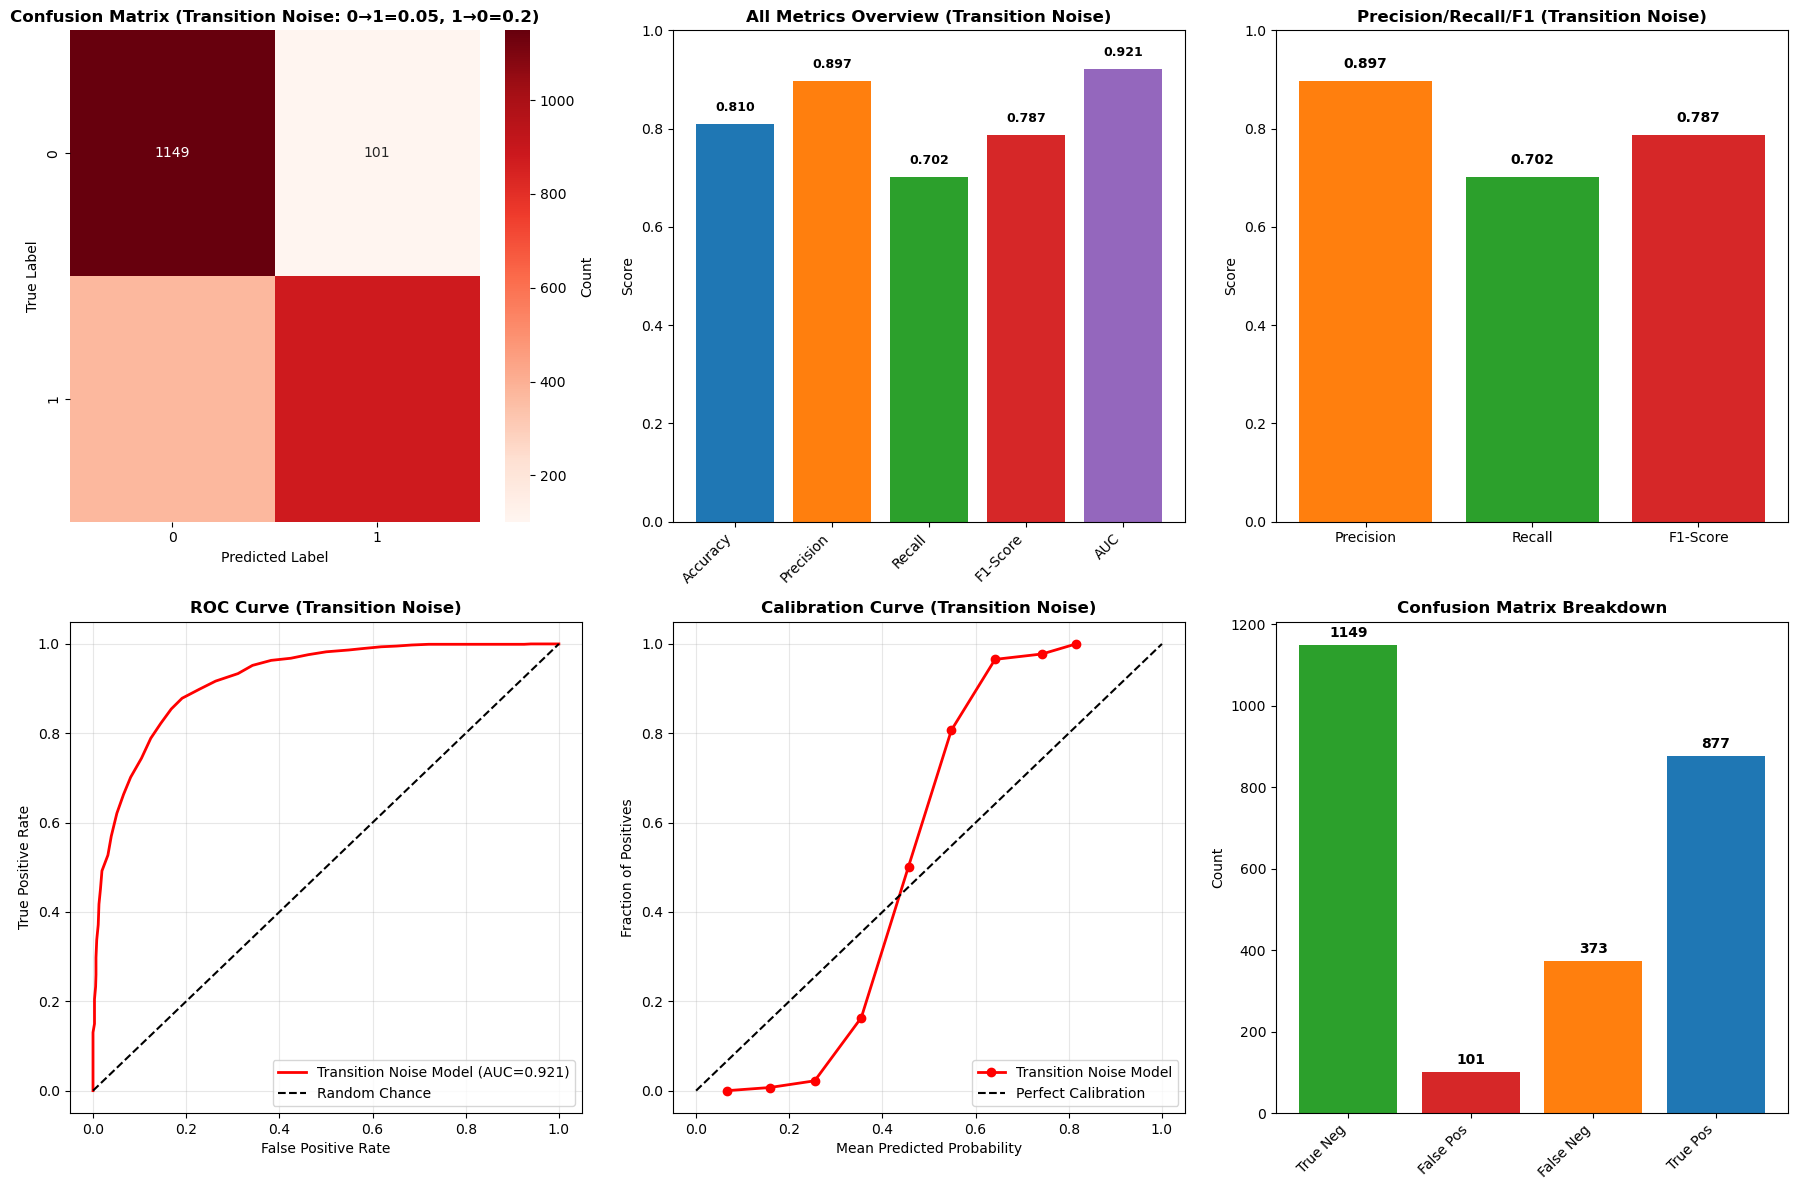


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.75      0.92      0.83      1250
     Default       0.90      0.70      0.79      1250

    accuracy                           0.81      2500
   macro avg       0.83      0.81      0.81      2500
weighted avg       0.83      0.81      0.81      2500



In [47]:
"""
KNN MODEL WITH CONFUSION MATRIX NOISE (Transition Matrix: 0→1=20%, 1→0=5%)
===========================================================================
This script mirrors the Random Forest confusion matrix noise analysis but applies it to the KNN model.
- Introduces label noise via transition matrix with two independent flip probabilities:
  * eta_01 = 20%: Probability of flipping Class 0 → Class 1
  * eta_10 = 5%:  Probability of flipping Class 1 → Class 0
- This creates asymmetric bidirectional noise (different flip rates for each class)
- Differs from simple asymmetric noise by allowing flips in BOTH directions simultaneously
- Trains KNN model on the noisy labels with confusion matrix noise
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline and other noise models
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    """
    Applies label noise via transition matrix (confusion matrix noise).
    
    This method flips labels based on a noise transition matrix:
    - eta_01: Probability that a true Class 0 label is flipped to Class 1
    - eta_10: Probability that a true Class 1 label is flipped to Class 0
    
    Unlike symmetric or simple asymmetric noise, this allows independent 
    control of flip rates in both directions.
    
    Args:
        y: True labels array
        eta_01: Flip rate for 0→1 (e.g., 0.20 = 20% of 0s become 1s)
        eta_10: Flip rate for 1→0 (e.g., 0.05 = 5% of 1s become 0s)
        random_state: Random seed for reproducibility
    
    Returns:
        y_noisy: Labels with confusion matrix noise applied
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    
    # Flip Class 0 → Class 1
    idx0 = np.where(y == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1
    
    # Flip Class 1 → Class 0
    idx1 = np.where(y == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0
    
    return y_noisy

# Set confusion matrix noise parameters
eta_01 = 0.05  # 20% of Class 0 → Class 1
eta_10 = 0.20  # 5% of Class 1 → Class 0

# Apply confusion matrix noise to training labels
y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)
print("Original label distribution:", np.bincount(y_train))
print("Confusion matrix noisy label distribution:", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

# Train KNN model with noisy labels
knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k,  # Use your optimized K value (e.g., 78)
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

# Make predictions
y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

# Calculate all metrics
acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store results
if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

# Print summary statistics
print(f"\n{'='*60}")
print(f"KNN WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# Create comprehensive visualization (matching Random Forest layout)
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Transition Noise: 0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Transition Noise Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Transition Noise Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 4 = Label Noise via Confusion Matrix (Transition Matrix Noise) 0->1(50%) and 1->0(10%)

Original label distribution: [3750 3750]
Confusion matrix noisy label distribution: [2250 5250]
Noise rates: 0→1=0.5, 1→0=0.1

KNN WITH CONFUSION MATRIX NOISE (0→1=0.5, 1→0=0.1)
Accuracy:  0.5184
Precision: 0.5094
Recall:    1.0000
F1 Score:  0.6749
AUC Score: 0.8792



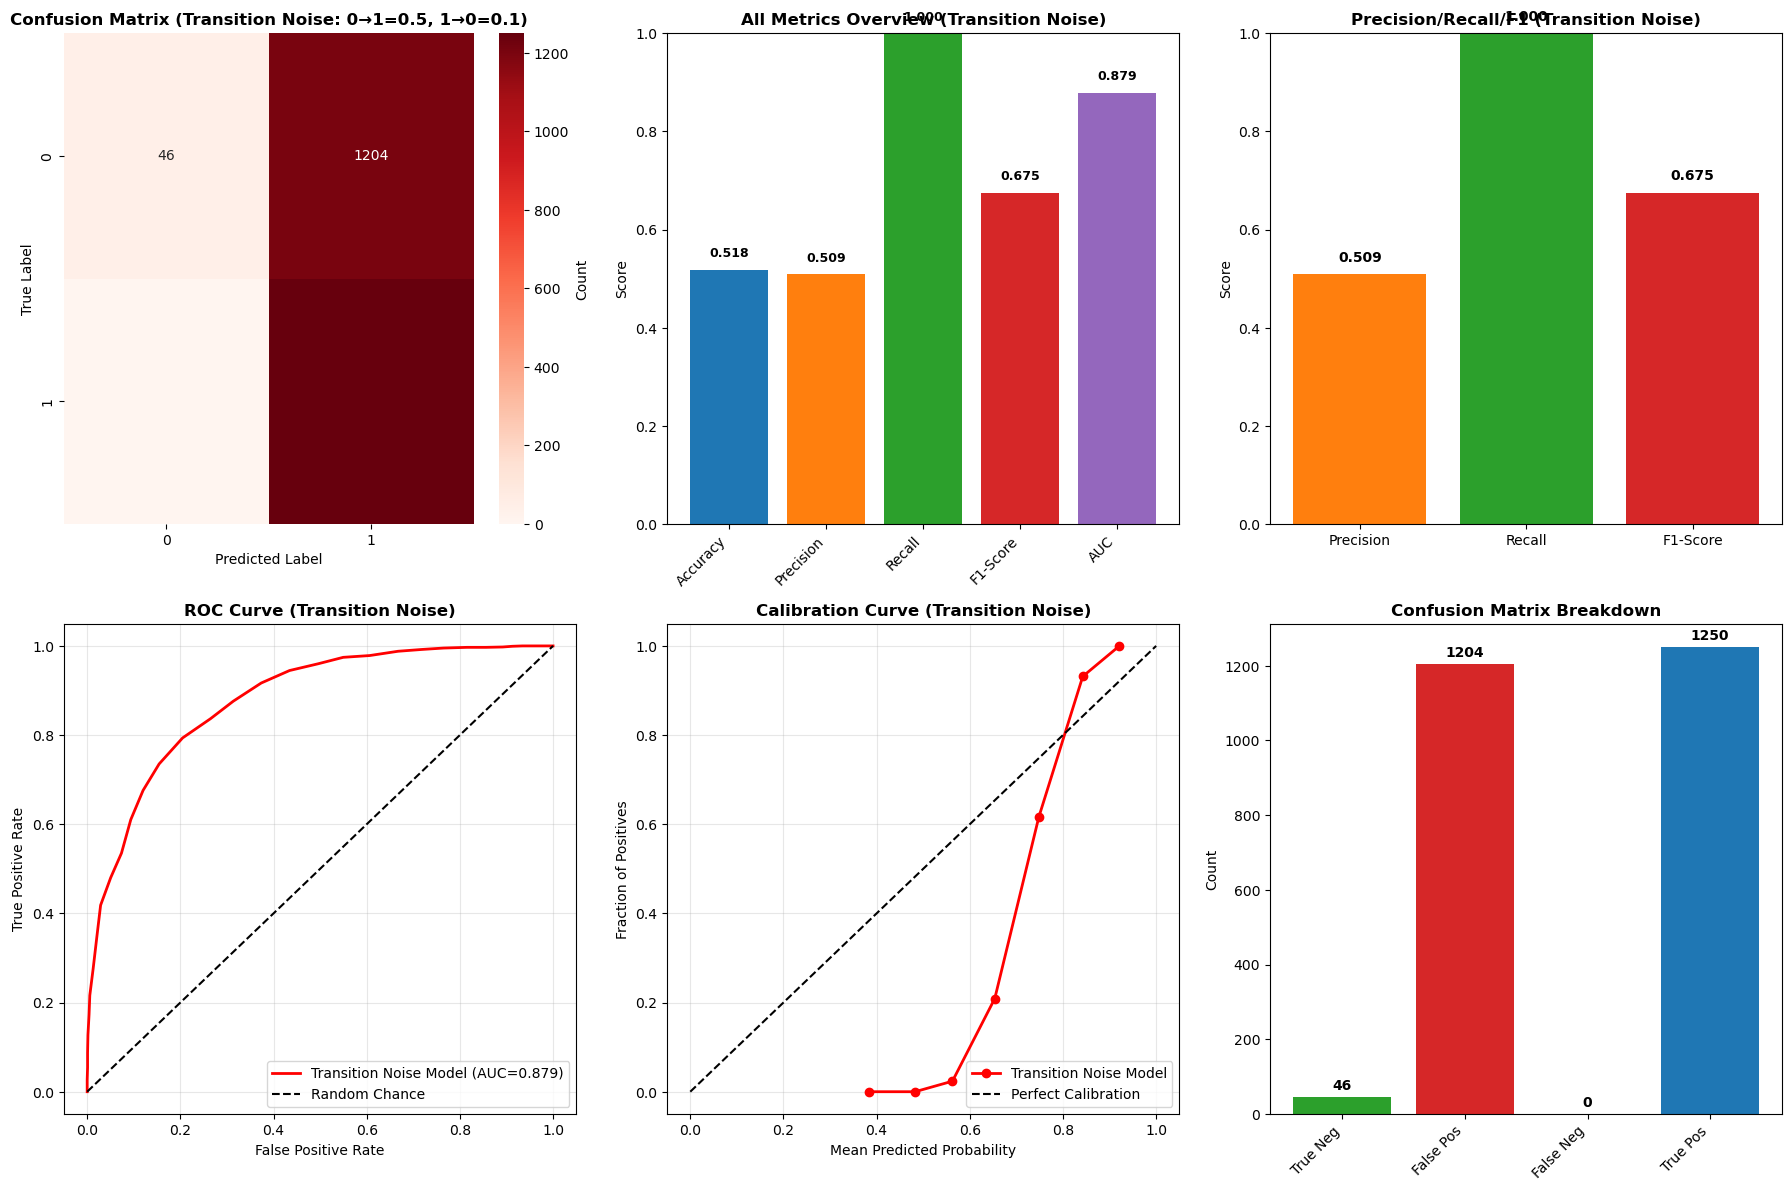


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       1.00      0.04      0.07      1250
     Default       0.51      1.00      0.67      1250

    accuracy                           0.52      2500
   macro avg       0.75      0.52      0.37      2500
weighted avg       0.75      0.52      0.37      2500



In [48]:
"""
KNN MODEL WITH CONFUSION MATRIX NOISE (Transition Matrix: 0→1=20%, 1→0=5%)
===========================================================================
This script mirrors the Random Forest confusion matrix noise analysis but applies it to the KNN model.
- Introduces label noise via transition matrix with two independent flip probabilities:
  * eta_01 = 20%: Probability of flipping Class 0 → Class 1
  * eta_10 = 5%:  Probability of flipping Class 1 → Class 0
- This creates asymmetric bidirectional noise (different flip rates for each class)
- Differs from simple asymmetric noise by allowing flips in BOTH directions simultaneously
- Trains KNN model on the noisy labels with confusion matrix noise
- Evaluates using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration
- Creates comprehensive visualizations matching the Random Forest analysis
- Stores all results for comparison with baseline and other noise models
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    """
    Applies label noise via transition matrix (confusion matrix noise).
    
    This method flips labels based on a noise transition matrix:
    - eta_01: Probability that a true Class 0 label is flipped to Class 1
    - eta_10: Probability that a true Class 1 label is flipped to Class 0
    
    Unlike symmetric or simple asymmetric noise, this allows independent 
    control of flip rates in both directions.
    
    Args:
        y: True labels array
        eta_01: Flip rate for 0→1 (e.g., 0.20 = 20% of 0s become 1s)
        eta_10: Flip rate for 1→0 (e.g., 0.05 = 5% of 1s become 0s)
        random_state: Random seed for reproducibility
    
    Returns:
        y_noisy: Labels with confusion matrix noise applied
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    
    # Flip Class 0 → Class 1
    idx0 = np.where(y == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1
    
    # Flip Class 1 → Class 0
    idx1 = np.where(y == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0
    
    return y_noisy

# Set confusion matrix noise parameters
eta_01 = 0.50  # 20% of Class 0 → Class 1
eta_10 = 0.10  # 5% of Class 1 → Class 0

# Apply confusion matrix noise to training labels
y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)
print("Original label distribution:", np.bincount(y_train))
print("Confusion matrix noisy label distribution:", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

# Train KNN model with noisy labels
knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k,  # Use your optimized K value (e.g., 78)
    metric='manhattan'
)
knn_noisy.fit(X_train_pca, y_train_noisy)

# Make predictions
y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

# Calculate all metrics
acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store results
if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

# Print summary statistics
print(f"\n{'='*60}")
print(f"KNN WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# Create comprehensive visualization (matching Random Forest layout)
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Transition Noise: 0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Comparison
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Transition Noise Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Transition Noise Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. Confusion Matrix Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 4 = Label Noise via Confusion Matrix (Transition Matrix Noise) 0->1(10%) and 1->0(50%)

Original label distribution: [3750 3750]
Confusion matrix noisy label distribution: [5250 2250]
Noise rates: 0→1=0.1, 1→0=0.5

RANDOM FOREST WITH CONFUSION MATRIX NOISE (0→1=0.1, 1→0=0.5)
Accuracy:  0.6400
Precision: 0.9972
Recall:    0.2808
F1 Score:  0.4382
AUC Score: 0.9837



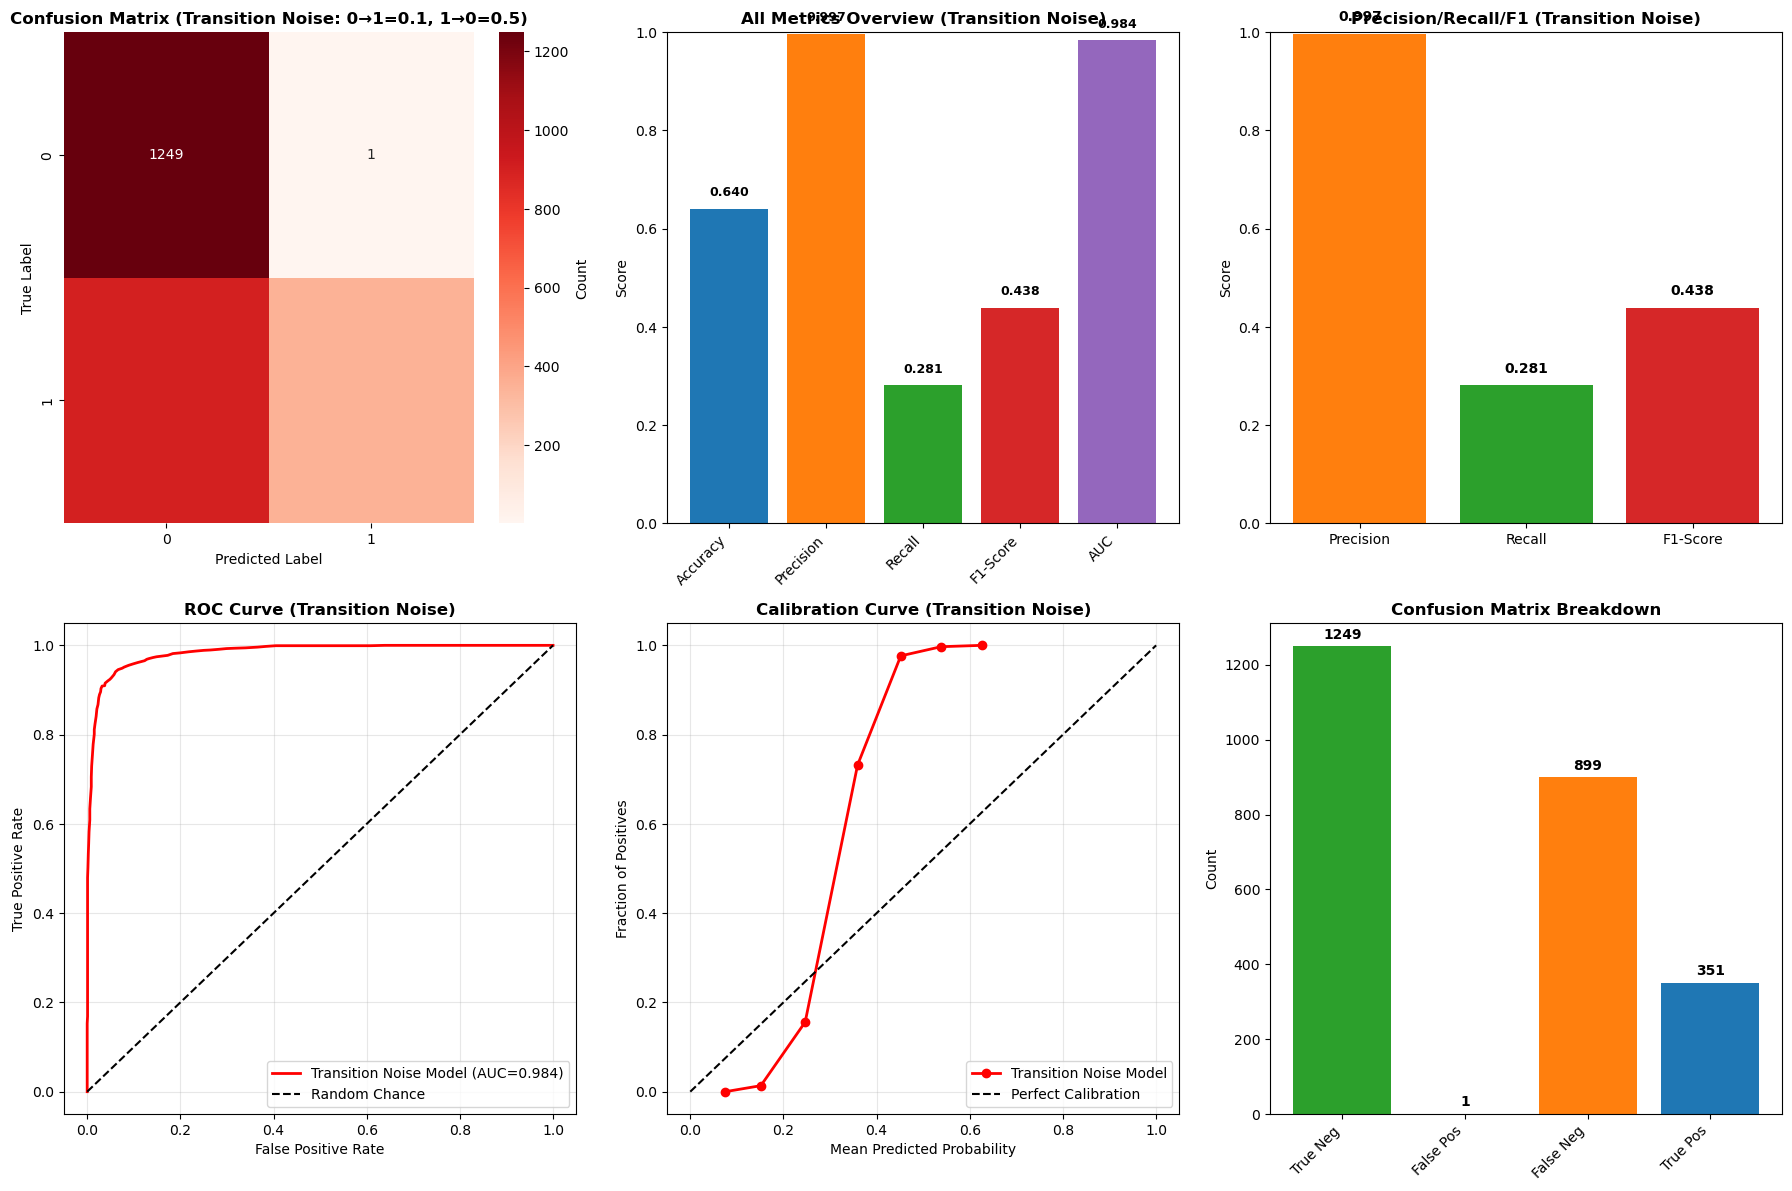


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.58      1.00      0.74      1250
     Default       1.00      0.28      0.44      1250

    accuracy                           0.64      2500
   macro avg       0.79      0.64      0.59      2500
weighted avg       0.79      0.64      0.59      2500



In [49]:
"""
I introduced label noise via confusion matrix (transition matrix) to my training labels.
I used two noise parameters: eta_01 for flipping class 0 to 1, and eta_10 for flipping class 1 to 0.
I trained a new Random Forest model on the noisy labels with confusion matrix noise.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the confusion matrix noisy model's performance.
I stored all results for comparison with baseline and other noise models.
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx0 = np.where(y == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1
    idx1 = np.where(y == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0
    return y_noisy

eta_01 = 0.10
eta_10 = 0.50

y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)
print("Original label distribution:", np.bincount(y_train))
print("Confusion matrix noisy label distribution:", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Transition Noise: 0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Transition Noise Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Transition Noise Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))